In [1]:
import numpy as np
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats
from functools import partial
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from bayesian_changepoint_detection.priors import const_prior
from scipy.signal import argrelextrema

Use scipy logsumexp().


## Collect the 2021 State Contact Index into one file

In [2]:

# directory = './State_Contact_Index/'
# dates=set()
# states=set()

# CI = {}
# CCI = {}
# first = True

# for filename in os.listdir(directory):
#     if filename.endswith(".csv") and "2021" in filename:
#         str_date=filename.split('.')[0].split('_')[1].strip()
#         dates.add(str_date)
#         with open(directory+filename,'r') as fr:
#             line=fr.readline()#header
#             while True:
#                 line=fr.readline()
#                 if len(line)==0:
#                     break
#                 data=line.split(',')
#                 state=data[0]
#                 if first:
#                     states.add(state)
#                 CI[(state,str_date)]=float(data[1])
#                 CCI[(state,str_date)]=data[2].strip().replace("%",'')
#             first = False
        
# print(len(dates))
# print(len(states))
# print(len(CI),CI)
# print(len(CCI),CCI)

365
51
18615 {('Florida', '2021-04-20'): 6.61, ('Alabama', '2021-04-20'): 6.09, ('Texas', '2021-04-20'): 5.34, ('Tennessee', '2021-04-20'): 5.1, ('South Carolina', '2021-04-20'): 4.99, ('Louisiana', '2021-04-20'): 4.95, ('New York', '2021-04-20'): 4.72, ('Georgia', '2021-04-20'): 4.61, ('Arkansas', '2021-04-20'): 4.58, ('Oklahoma', '2021-04-20'): 4.37, ('Arizona', '2021-04-20'): 4.13, ('Nevada', '2021-04-20'): 4.08, ('Mississippi', '2021-04-20'): 4.05, ('Hawaii', '2021-04-20'): 3.95, ('North Carolina', '2021-04-20'): 3.83, ('Missouri', '2021-04-20'): 3.8, ('Delaware', '2021-04-20'): 3.67, ('California', '2021-04-20'): 3.41, ('New Jersey', '2021-04-20'): 3.37, ('Ohio', '2021-04-20'): 3.23, ('Illinois', '2021-04-20'): 3.19, ('Kentucky', '2021-04-20'): 3.13, ('Indiana', '2021-04-20'): 3.02, ('Nebraska', '2021-04-20'): 3.0, ('Kansas', '2021-04-20'): 2.88, ('Utah', '2021-04-20'): 2.8, ('Maryland', '2021-04-20'): 2.78, ('Pennsylvania', '2021-04-20'): 2.72, ('Connecticut', '2021-04-20'): 2.64

In [3]:

# fw=open('2021data/2021_state_cuebiq_CCI.txt','w')
# fw2=open('2021data/2021_state_cuebiq_CCI_YOY.txt','w')
# dates=sorted(dates, key=lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
# print(dates)
# print(states)
# fw.write('date,'+','.join(states))
# fw2.write('date,'+','.join(states))
# for date in dates:
#     fw.write('\n'+date)
#     fw2.write('\n'+date)
#     for state in states:
#         fw.write(','+str(CI[(state,date)]))
#         fw2.write(','+str(CCI[(state,date)]))
        
# fw.close()
# fw2.close()

['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021

## Visualize the contact index

(365, 1)


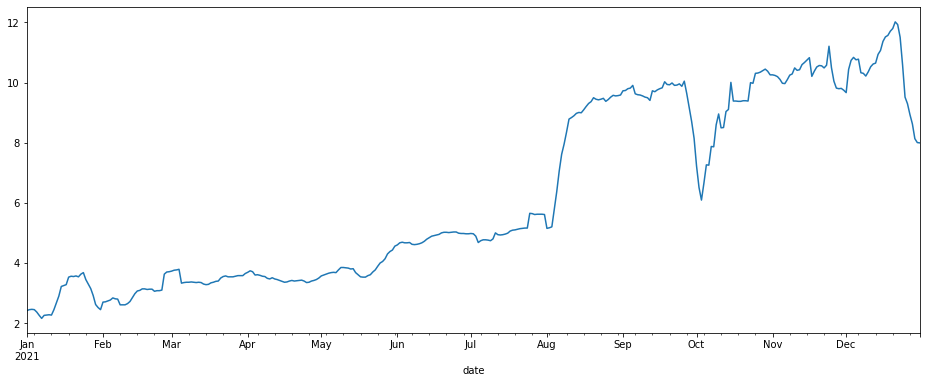

In [4]:
## Cuebiq Contact Index data

path="./2021data/"
df=pd.read_csv(path+'2021_state_cuebiq_CCI.txt',dtype=object,sep = ",")
df = df[["date","California"]]
df.set_index("date",inplace = True)

distance_df = df.copy()
distance_df.index = pd.to_datetime(df.index) # convert to datetime
distance_df.columns=['Distance']
distance_df['Distance'] = pd.to_numeric(distance_df['Distance'])
distance_df=distance_df.sort_index(ascending=True) # select ranges of dates, sort the rows by date first
# start = distance_df.index.searchsorted(dt.datetime(2021, 9, 10))
#end = distance_df.index.searchsorted(dt.datetime(2021, 11, 2))
# distance_df = distance_df.iloc[start:]
print(distance_df.shape)
distance_df['Distance'].plot(figsize = (16,6))
plt.show()


## Visualize the NYT data/hospital data

In [5]:
hospitial_data = pd.read_csv('2021data/nyt-us-states.csv')
print(hospitial_data.head())

         date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0


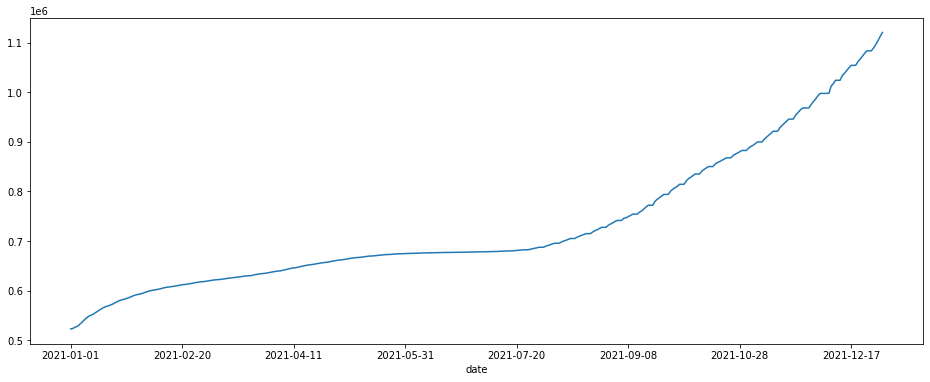

In [6]:
df = hospitial_data[hospitial_data['state'] == 'Wisconsin']
start_date = '2021-01-01'
end_date = '2021-12-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date)
NYT_hospitial_data = df.loc[mask]

NYT_hospitial_data.set_index('date',inplace=True)
NYT_hospitial_data.sort_index(ascending=True,inplace = True) # select ranges of dates, sort the rows by date first
NYT_hospitial_data['cases'].plot(figsize = (16,6))
plt.show()

In [7]:
NYT_hospitial_data['cases']

date
2021-01-01     522523
2021-01-02     523652
2021-01-03     526245
2021-01-04     527871
2021-01-05     531890
               ...   
2021-12-27    1089123
2021-12-28    1096118
2021-12-29    1103932
2021-12-30    1112659
2021-12-31    1120669
Name: cases, Length: 365, dtype: int64

In [8]:
distance_df["Distance"]

date
2021-01-01    2.43
2021-01-02    2.46
2021-01-03    2.47
2021-01-04    2.46
2021-01-05    2.38
              ... 
2021-12-27    8.94
2021-12-28    8.63
2021-12-29    8.14
2021-12-30    8.01
2021-12-31    8.00
Name: Distance, Length: 365, dtype: float64

In [9]:
prev = hospitial_data[(hospitial_data['state'] == 'Wisconsin')&(hospitial_data['date'] == '2020-12-31')]["cases"].iloc[0]
prev

520438

## Look at Daily cases

(365, 4)
date
2021-01-01    2085
2021-01-02    1129
2021-01-03    2593
2021-01-04    1626
2021-01-05    4019
              ... 
2021-12-27    5552
2021-12-28    6995
2021-12-29    7814
2021-12-30    8727
2021-12-31    8010
Length: 365, dtype: int64


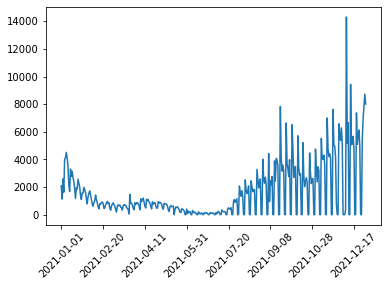

In [10]:
print(NYT_hospitial_data.shape)


y=NYT_hospitial_data['cases']
daily_hospitial_data = [None] * len(y)
daily_hospitial_data[0] = y[0]-prev
for i in range(1,len(y)):
    daily_hospitial_data[i] = y[i] - y[i-1]

daily_hospitial_data=pd.Series(daily_hospitial_data)
daily_hospitial_data.index =NYT_hospitial_data.index
print(daily_hospitial_data)
fig,ax = plt.subplots()
ax.plot(daily_hospitial_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xticks(rotation = 45)
plt.show()


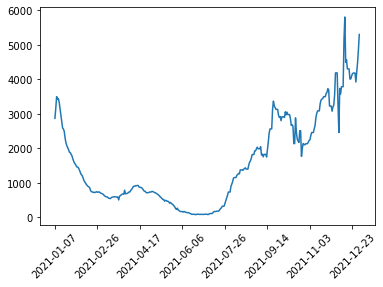

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

avg_daily_hospital_data = moving_average(daily_hospitial_data,7)
avg_daily_hospital_data=pd.Series(avg_daily_hospital_data)
avg_daily_hospital_data.index =NYT_hospitial_data.index[6:]
fig,ax = plt.subplots()
ax.plot(avg_daily_hospital_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xticks(rotation = 45)
plt.show()

## Correlation between CCI and Cases

In [13]:
## Correlation
x = np.array(distance_df['Distance'])
x = x.astype(float)
y = np.array(NYT_hospitial_data['cases'])
print(x,y)
print("length of CCI",len(x),"len of cases",len(y))
daily = np.array(daily_hospitial_data)
print(daily)
print("length of daily",len(daily))

r, p = scipy.stats.pearsonr(x, y)
print(r,p)
r, p = scipy.stats.pearsonr(x, daily)
print(r,p)

r, p = scipy.stats.spearmanr(x, y)
print(r,p)
r, p = scipy.stats.spearmanr(x, daily)
print(r,p)

[ 2.43  2.46  2.47  2.46  2.38  2.27  2.17  2.27  2.28  2.29  2.28  2.46
  2.68  2.91  3.23  3.26  3.29  3.54  3.57  3.56  3.58  3.55  3.64  3.69
  3.46  3.31  3.16  2.93  2.63  2.53  2.46  2.71  2.72  2.75  2.78  2.85
  2.82  2.81  2.62  2.62  2.62  2.66  2.73  2.86  2.99  3.08  3.1   3.15
  3.15  3.13  3.14  3.14  3.07  3.09  3.09  3.11  3.64  3.71  3.72  3.74
  3.77  3.78  3.8   3.34  3.36  3.37  3.37  3.38  3.37  3.36  3.37  3.36
  3.31  3.29  3.3   3.35  3.37  3.4   3.41  3.51  3.56  3.58  3.55  3.55
  3.55  3.57  3.59  3.59  3.59  3.66  3.7   3.75  3.72  3.61  3.62  3.6
  3.57  3.56  3.5   3.48  3.52  3.48  3.46  3.43  3.4   3.37  3.38  3.41
  3.43  3.41  3.42  3.43  3.44  3.41  3.36  3.37  3.41  3.43  3.46  3.51
  3.58  3.61  3.64  3.67  3.69  3.7   3.69  3.78  3.86  3.86  3.85  3.84
  3.81  3.82  3.69  3.62  3.55  3.54  3.54  3.59  3.62  3.71  3.78  3.9
  4.01  4.06  4.15  4.31  4.39  4.44  4.57  4.61  4.68  4.7   4.68  4.68
  4.69  4.63  4.62  4.63  4.65  4.68  4.73  4.8   4.8

In [14]:
avg_daily = np.array(avg_daily_hospital_data)
x_moving_average = moving_average(x,7)
print("len of avg_daily",len(avg_daily))
print("len of CCI avg",len(x_moving_average))
print(avg_daily)
print(x_moving_average)
r, p = scipy.stats.pearsonr(x_moving_average, avg_daily)
print(r,p)
r, p = scipy.stats.spearmanr(x_moving_average, avg_daily)
print(r,p)

len of avg_daily 359
len of CCI avg 359
[2867.14285714 3156.42857143 3497.42857143 3430.71428571 3438.71428571
 3337.         3145.85714286 2950.28571429 2749.71428571 2591.57142857
 2558.         2484.71428571 2288.42857143 2157.         2075.42857143
 2017.85714286 1961.14285714 1887.28571429 1877.42857143 1824.71428571
 1783.         1698.85714286 1627.57142857 1570.57142857 1537.57142857
 1492.         1453.71428571 1450.85714286 1413.57142857 1359.71428571
 1288.42857143 1234.57142857 1210.         1148.42857143 1071.57142857
 1029.71428571  983.28571429  947.85714286  918.71428571  892.57142857
  880.57142857  847.85714286  767.57142857  741.28571429  734.
  718.14285714  724.85714286  715.28571429  725.57142857  739.57142857
  722.14285714  730.          734.28571429  712.42857143  697.57142857
  688.28571429  672.71428571  662.          625.42857143  610.57142857
  591.71428571  590.57142857  580.14285714  551.28571429  549.28571429
  538.28571429  557.42857143  578.          5

## Some thoughts
update the CCI data to be the whole 2021?

inconsistent result from pearson (linear relationship between X and Y)and spearman (monotonic relationship between X and Y)

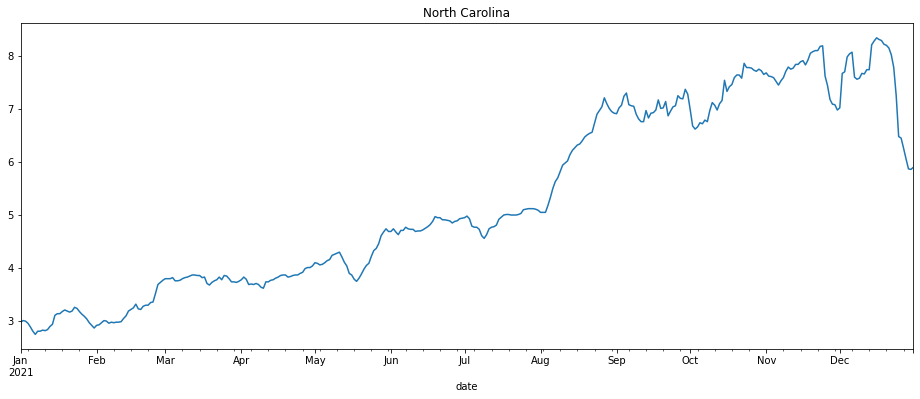

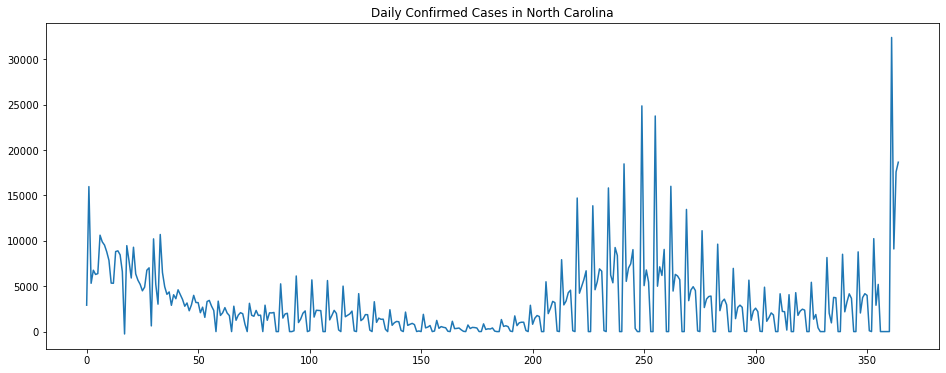

North Carolina 0.03180768979294781 0.5446781500619469
North Carolina -0.12840434204377285 0.014091696299646654
pearson from average North Carolina 0.06967126493767728 0.18781207509612338
spearman from average North Carolina 0.02810051740439282 0.5956427844116383


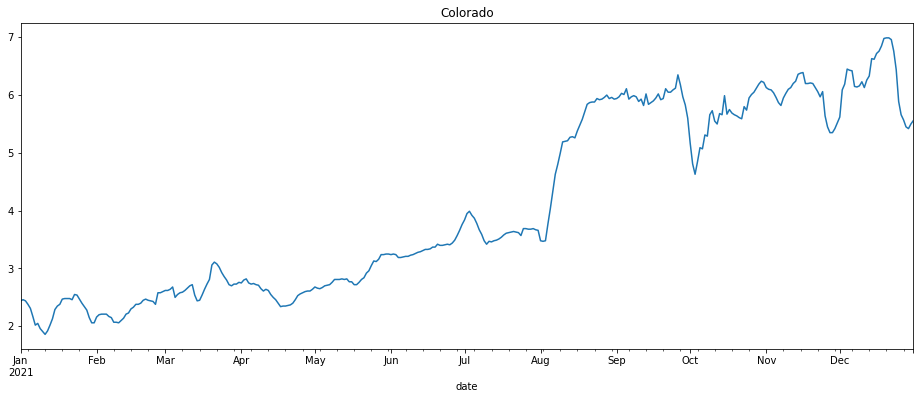

Colorado 0.34651589350344725 9.787787564209385e-12
Colorado 0.15524545195615827 0.002941015227653211
pearson from average Colorado 0.5521037382748457 4.9555288128581976e-30
spearman from average Colorado 0.42655904889800045 2.6363191239498206e-17


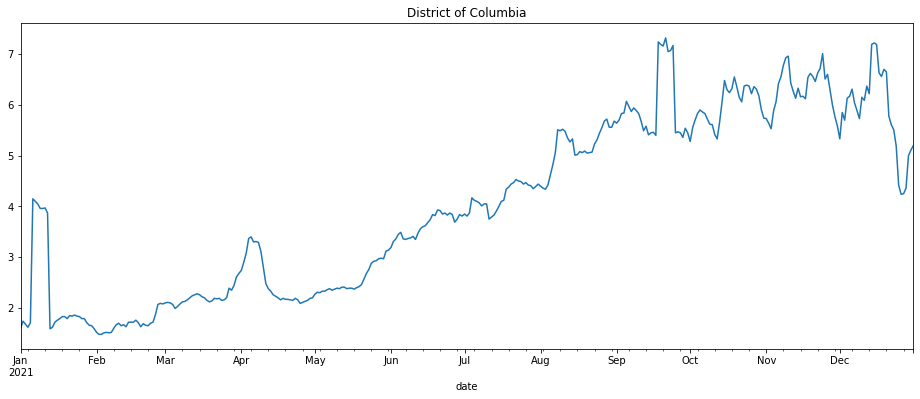

District of Columbia 0.07603276213892043 0.1471364546562261
District of Columbia -0.15930795585702098 0.002268282721120718
pearson from average District of Columbia 0.15015638657320518 0.004353837646131395
spearman from average District of Columbia 0.04948426696402557 0.3498418792245678


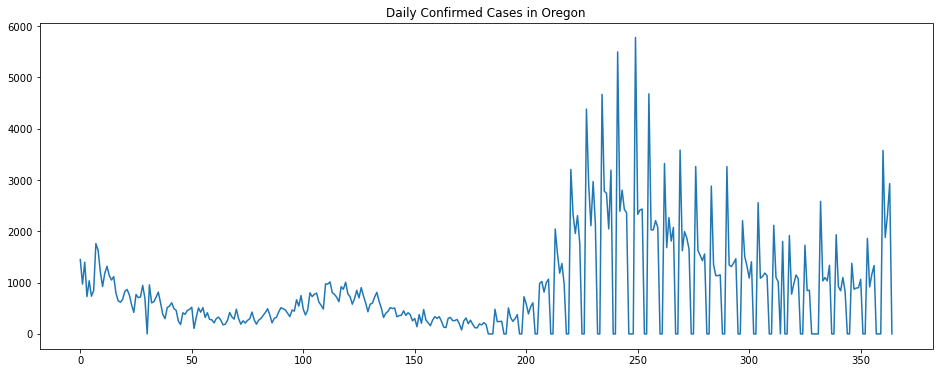

Oregon 0.3270300898653415 1.519651710372266e-10
Oregon 0.13287855003358634 0.01104690115265958
pearson from average Oregon 0.5585747417782356 7.664462833225157e-31
spearman from average Oregon 0.47371322152394735 1.7604622090799632e-21


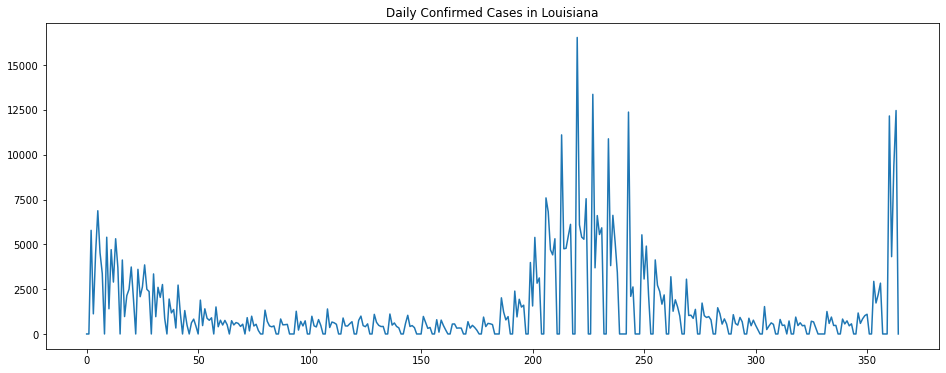

Louisiana -0.009258312915301142 0.8600764180003929
Louisiana -0.0627668431947508 0.23160858310483554
pearson from average Louisiana -0.01438950261190371 0.7858485578197643
spearman from average Louisiana -0.05670535920730635 0.28393183148967743


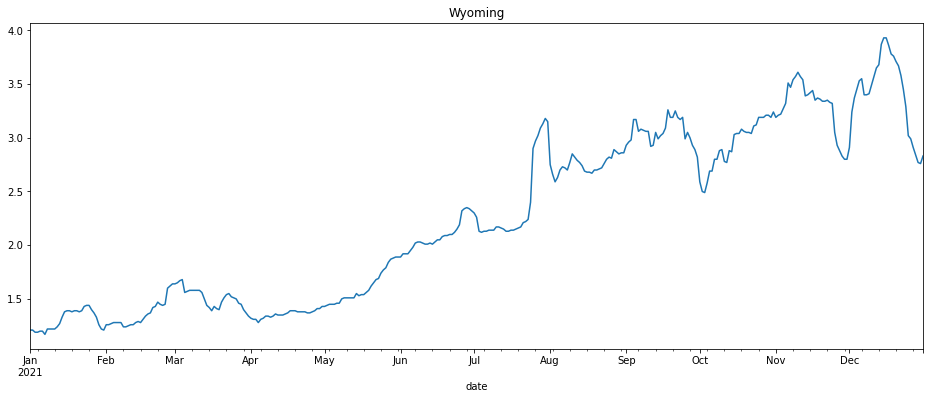

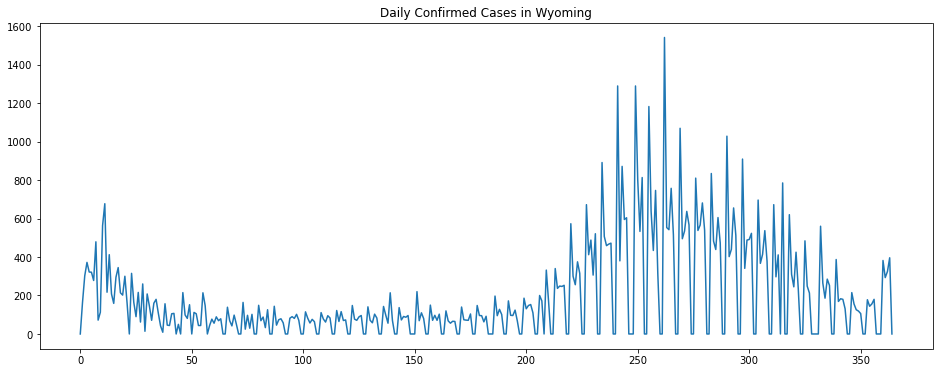

Wyoming 0.34811033377415945 7.753481828498808e-12
Wyoming 0.194629799115935 0.00018293745102030738
pearson from average Wyoming 0.5656272504083263 9.562693999892417e-32
spearman from average Wyoming 0.5692699851614392 3.199972846772917e-32


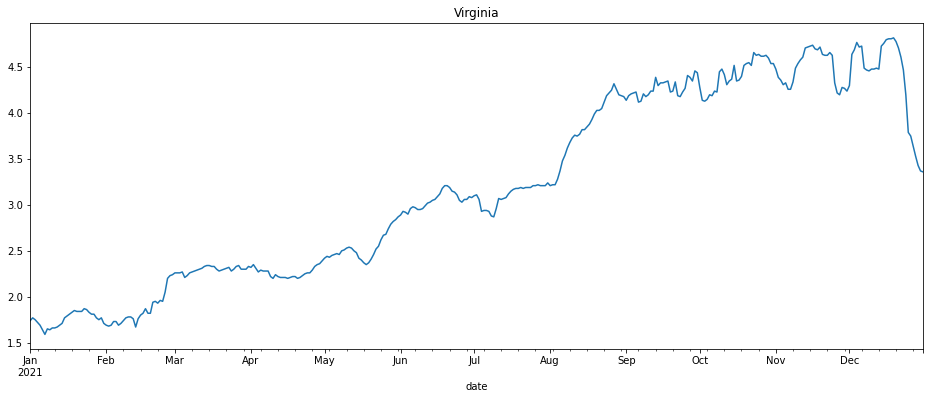

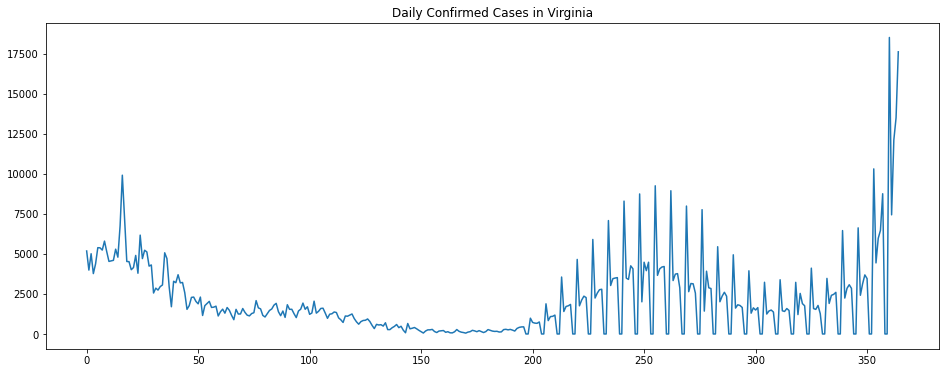

Virginia 0.007517284218530622 0.886189946282228
Virginia -0.1450205581072158 0.005506626933317344
pearson from average Virginia 0.021217985092908377 0.6886656855658102
spearman from average Virginia 0.0273880049939729 0.6050054558656686


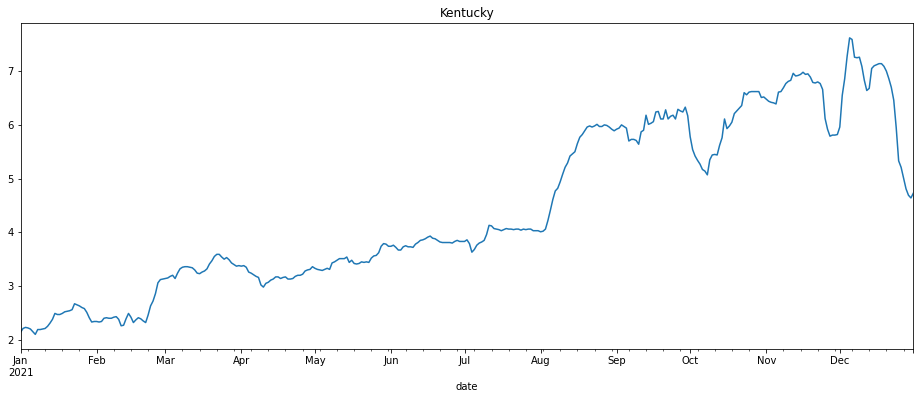

Kentucky 0.2282395745151783 1.0636297758209634e-05
Kentucky 0.02510905805461284 0.6325520986655406
pearson from average Kentucky 0.3586806466015092 2.4376861881316107e-12
spearman from average Kentucky 0.2801026339370046 6.772880695234422e-08


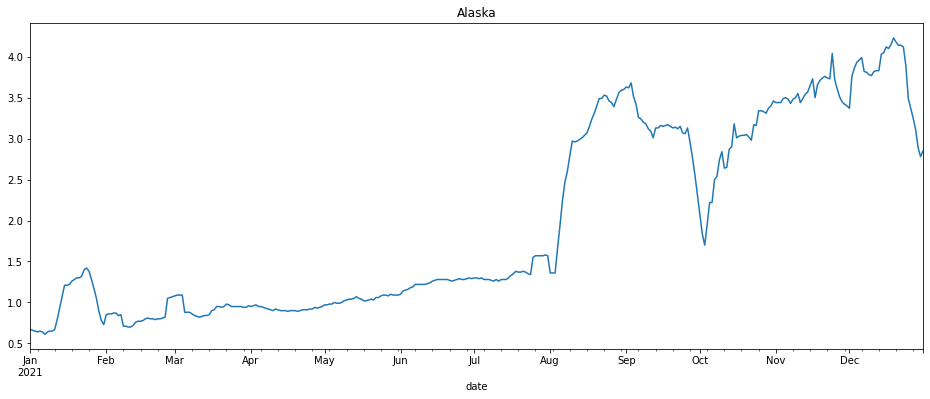

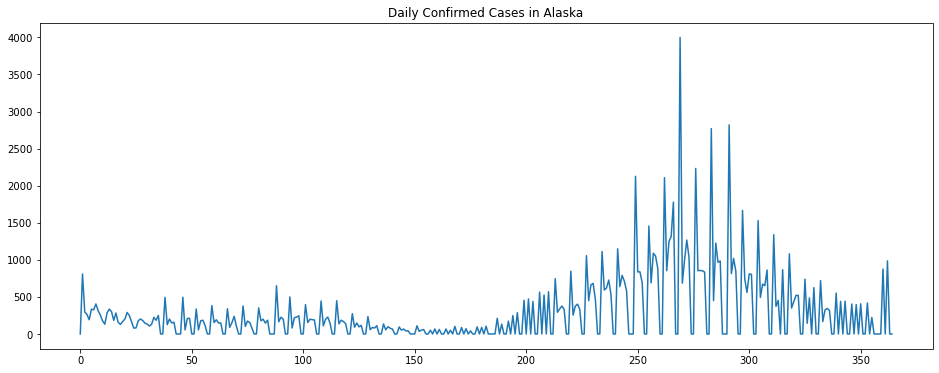

Alaska 0.33453856500953333 5.403400524251934e-11
Alaska 0.1553911754780002 0.002914045603796344
pearson from average Alaska 0.5727321646995633 1.116267314028277e-32
spearman from average Alaska 0.5254911110472229 7.077272576230949e-27


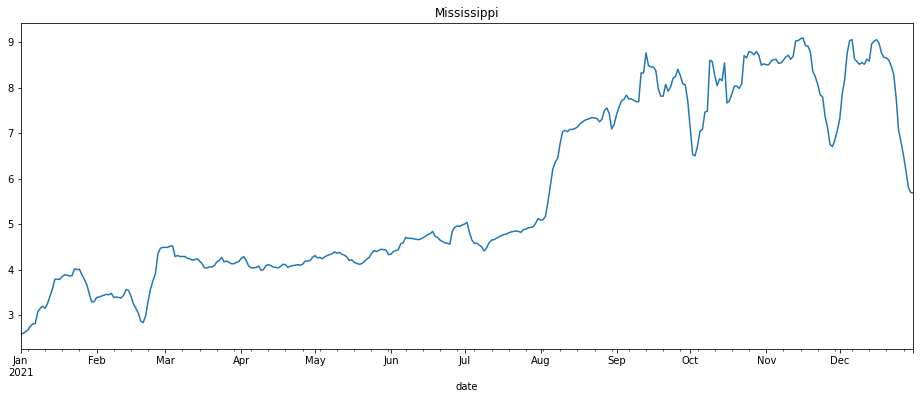

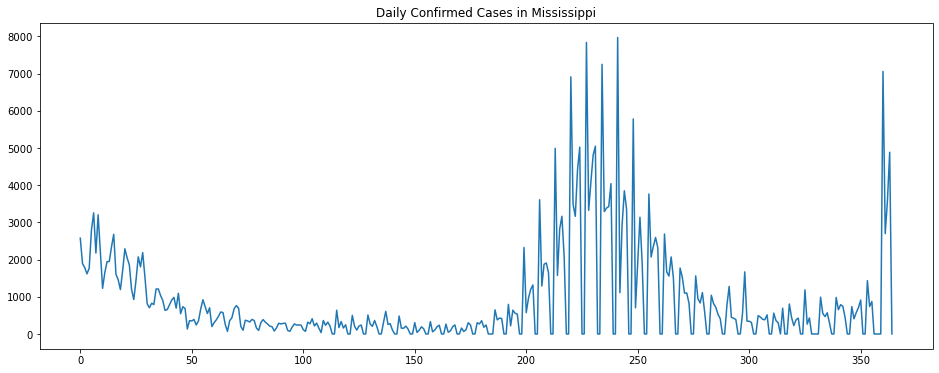

Mississippi 0.10240405777096442 0.05059983375277619
Mississippi -0.0747605684405189 0.1540430837423965
pearson from average Mississippi 0.17370496854210038 0.0009500342619584243
spearman from average Mississippi 0.15146509272553635 0.004021649390001964


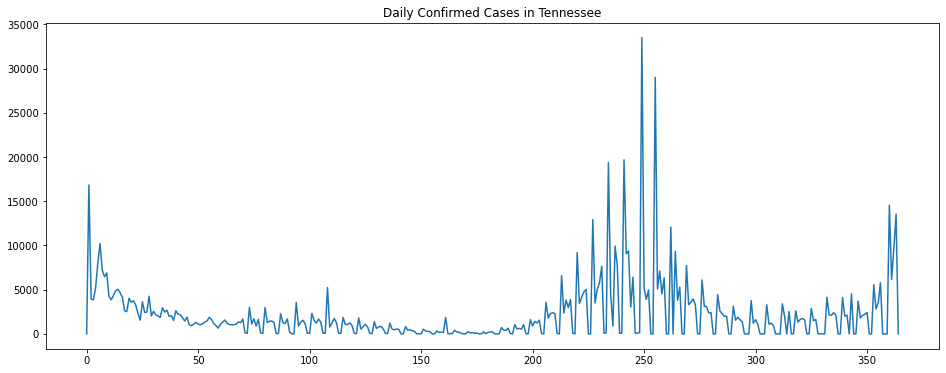

Tennessee 0.10418475175000269 0.0466972925330744
Tennessee -0.09439854353075523 0.0716524713508609
pearson from average Tennessee 0.19364880623075148 0.00022308831897499602
spearman from average Tennessee 0.13528183158532942 0.01028514630025862


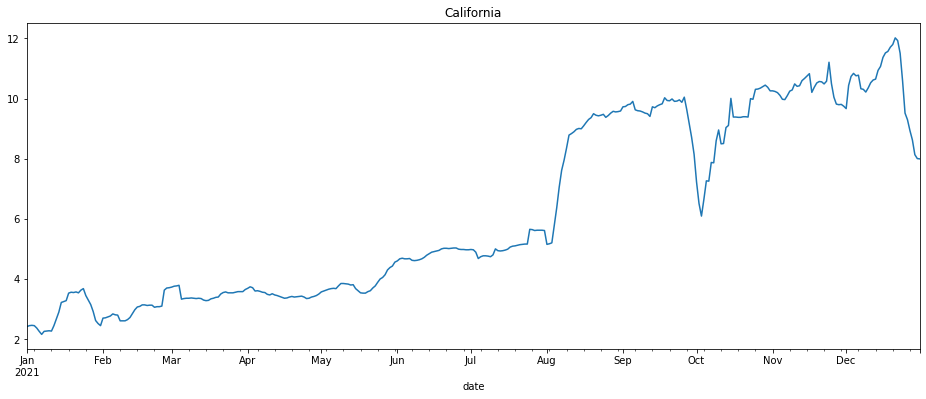

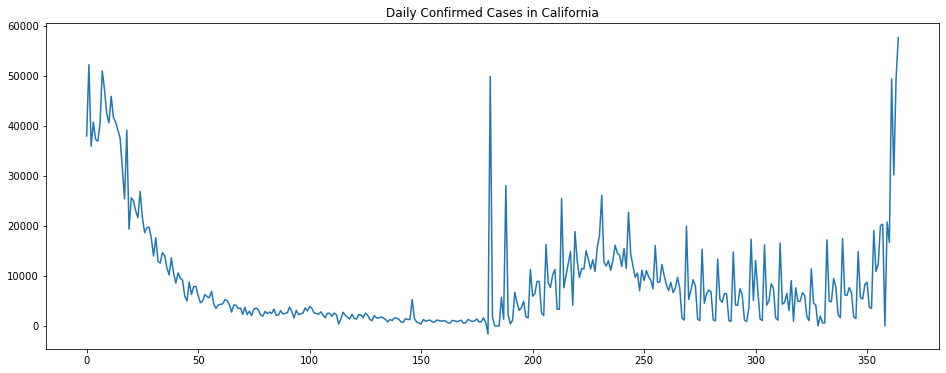

California -0.047675110363502186 0.36375987034791735
California 0.020530902039952767 0.695842971386121
pearson from average California -0.03996607813130012 0.45030307413540505
spearman from average California 0.14461912796802534 0.006050538389661018


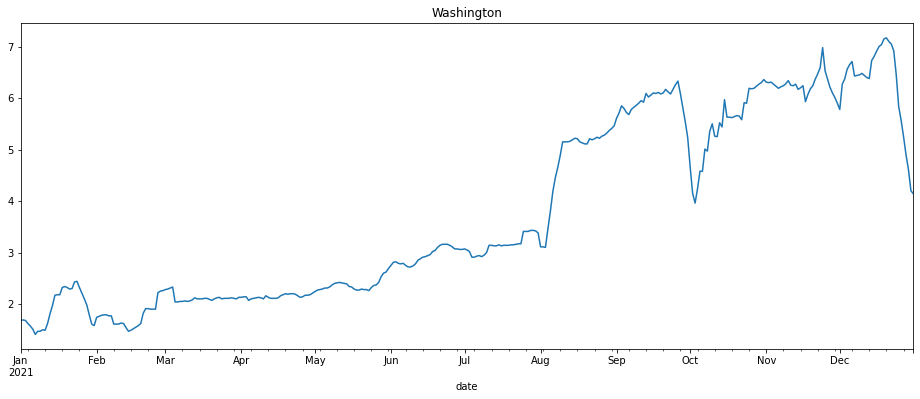

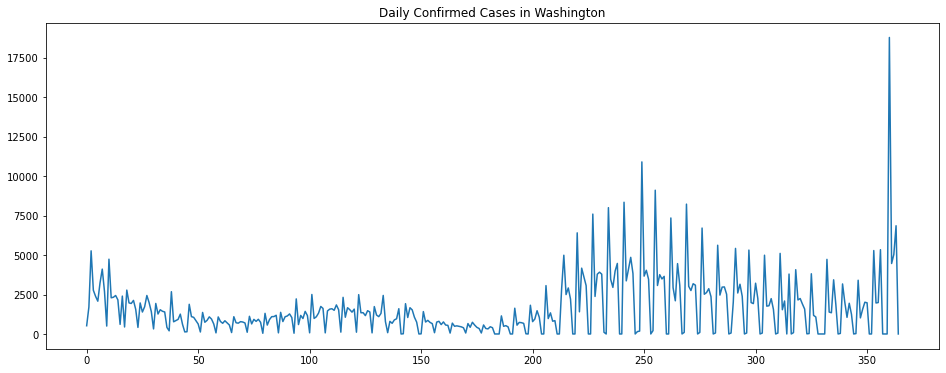

Washington 0.27215270732966773 1.280195076326524e-07
Washington 0.09289095008199447 0.076323896701229
pearson from average Washington 0.559544258383571 5.774292546799798e-31
spearman from average Washington 0.4461695314891046 5.793733086032062e-19


Idaho 0.39491202188430996 4.511062409004092e-15
Idaho 0.23176153120532403 7.688931514948867e-06
pearson from average Idaho 0.5448898324405722 3.7860149781459947e-29
spearman from average Idaho 0.4025911636111696 2.023401455307511e-15


New York -8.559086905846666e-05 0.9986997660002799
New York -0.19911315873597052 0.0001284477253859909
pearson from average New York 0.021754747505988555 0.681215725260489
spearman from average New York -0.20658897867829487 8.037773033665897e-05


New Mexico 0.3529989746490464 3.764124540602563e-12
New Mexico 0.09112415442724861 0.08211011851113498
pearson from average New Mexico 0.6304069616014087 3.609111431587894e-41
spearman from average New Mexico 0.4536854745231329 1.2545957704477656e-19


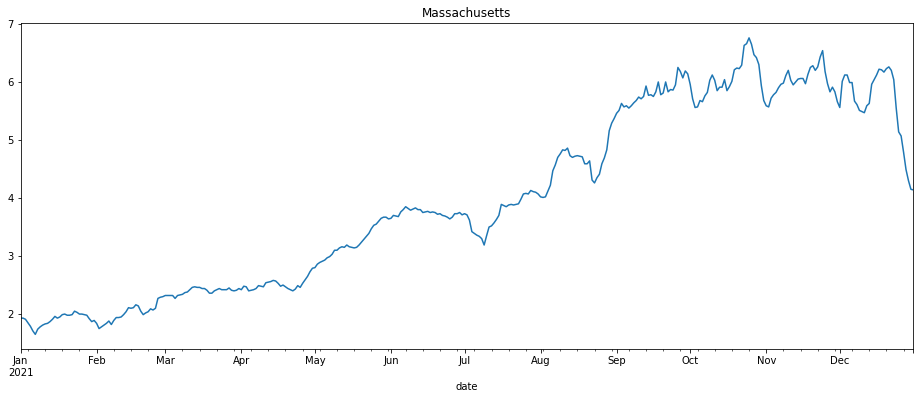

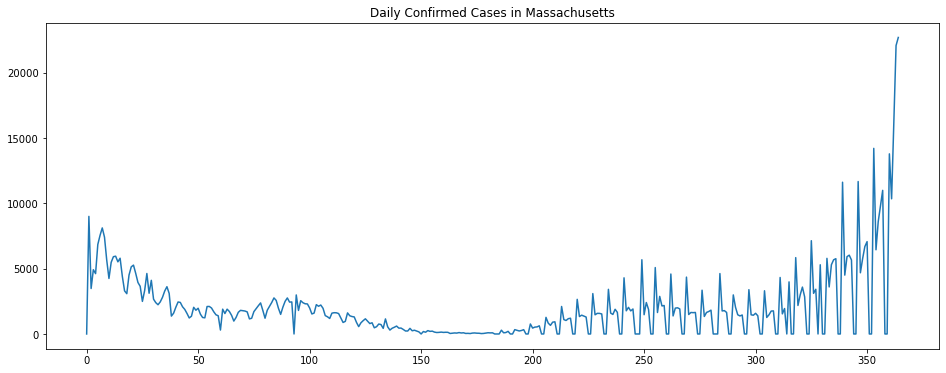

Massachusetts 0.01855935638551704 0.7237959111666982
Massachusetts -0.19182491582736388 0.000227331174812986
pearson from average Massachusetts 0.03724160306081479 0.48179975520563906
spearman from average Massachusetts -0.08362390439412785 0.1137197718865765


Wisconsin 0.44846679262887623 1.8429373357638138e-19
Wisconsin 0.1212996403194013 0.020446984971564587
pearson from average Wisconsin 0.7090338689809679 4.123977033092978e-56
spearman from average Wisconsin 0.5014672104343411 2.9372423159803466e-24


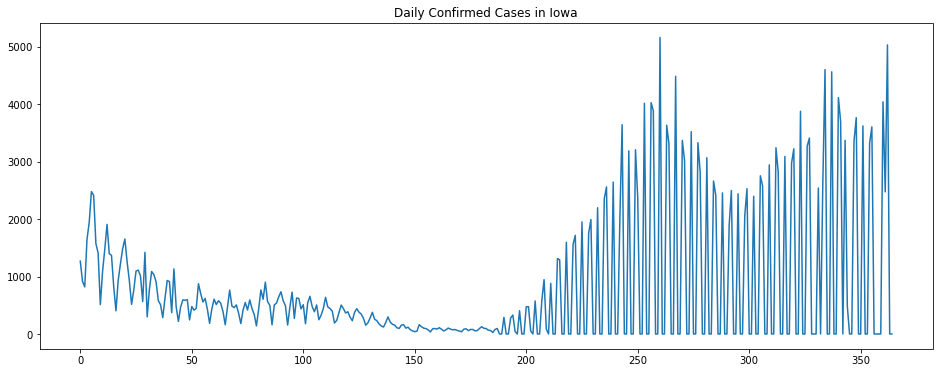

Iowa 0.3101885899764819 1.3969255175015876e-09
Iowa -0.22798524476089088 1.088632539876609e-05
pearson from average Iowa 0.6877626717591643 1.3401311923076274e-51
spearman from average Iowa 0.47010191136839674 3.8797013833668684e-21


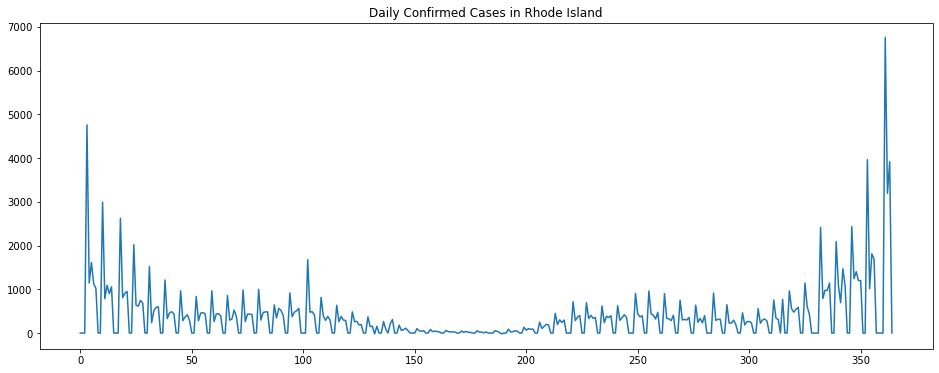

Rhode Island 0.015299030063936209 0.7708203247350054
Rhode Island -0.02003336857645023 0.7028601347910407
pearson from average Rhode Island 0.053347597608010555 0.3134614246144348
spearman from average Rhode Island -0.13690454423488466 0.009399702772798394


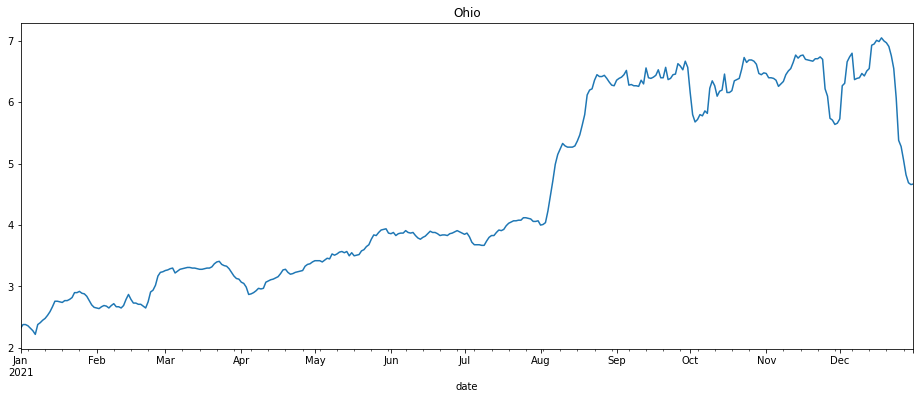

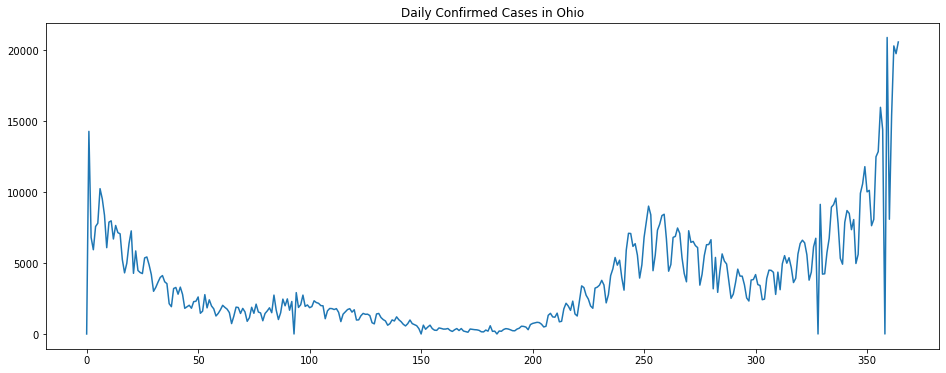

Ohio 0.4206370707670496 4.4020352283084615e-17
Ohio 0.34644906990275054 9.883547564152086e-12
pearson from average Ohio 0.5280660332293712 3.6033681378439146e-27
spearman from average Ohio 0.3628743422731166 1.2955246395866925e-12


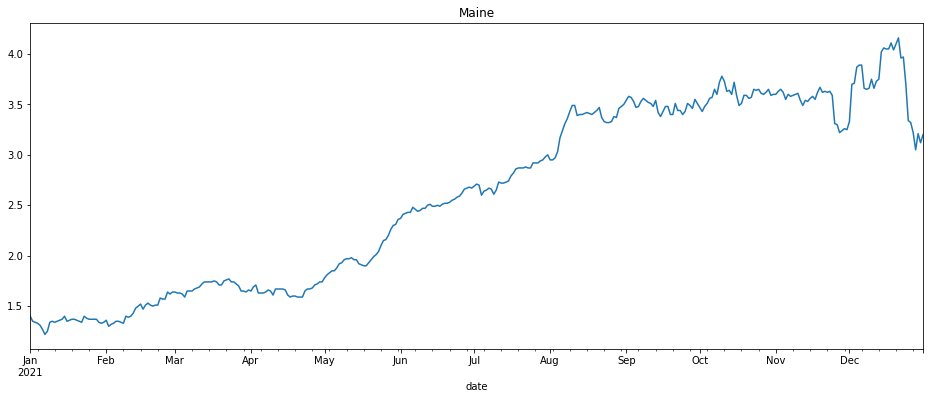

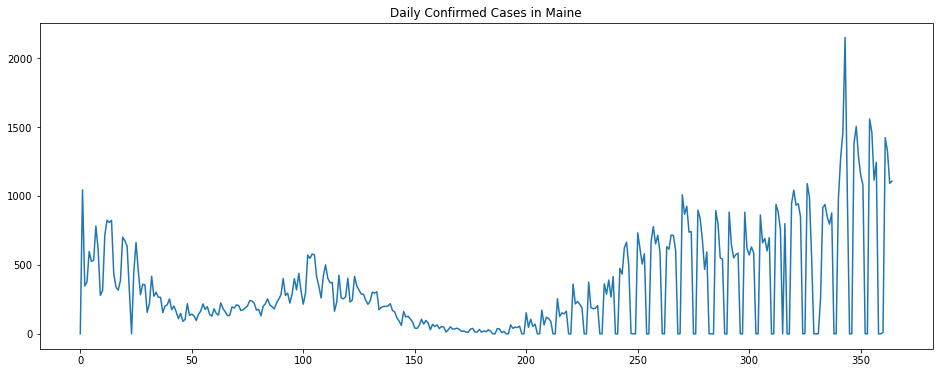

Maine 0.269549313154001 1.702731269031692e-07
Maine 0.060391149125957395 0.24978800218197464
pearson from average Maine 0.4001061764171815 3.111766781436143e-15
spearman from average Maine 0.36410130952786346 1.0748858744141016e-12


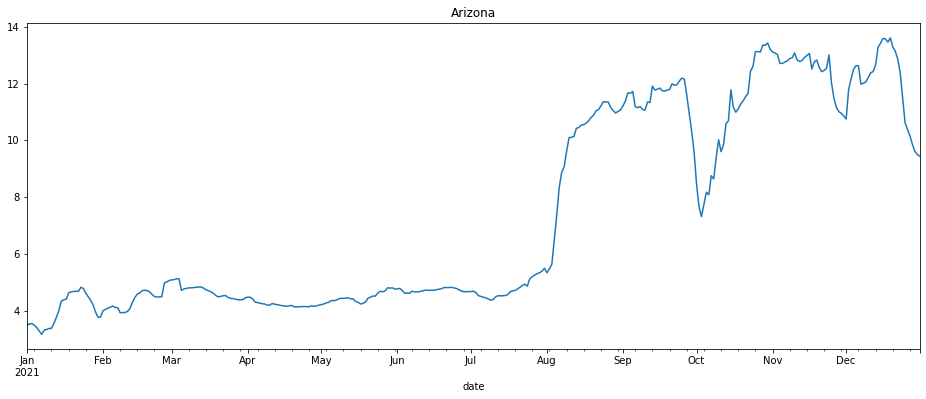

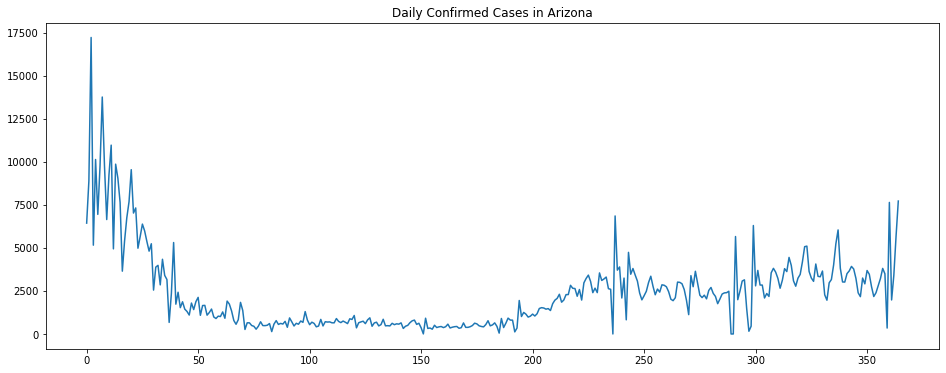

Arizona 0.19626652129799166 0.00016092779406018558
Arizona 0.3412595640768899 2.0903976882210323e-11
pearson from average Arizona 0.25943756286068215 6.225328557754515e-07
spearman from average Arizona 0.3931752192560838 1.0142813867068624e-14


Michigan 0.18945404264184984 0.00027251203848224764
Michigan -0.22208740358215776 1.852101227788815e-05
pearson from average Michigan 0.3952885259979211 7.095228893738011e-15
spearman from average Michigan 0.26312144764224665 4.249095005057779e-07


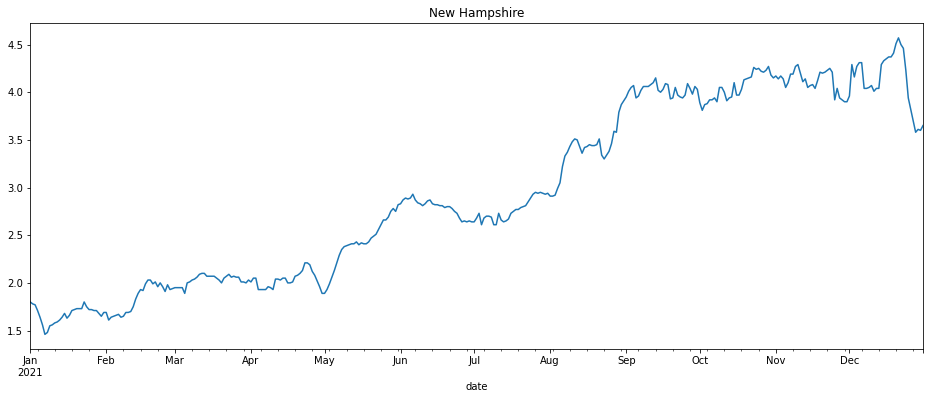

New Hampshire 0.2312113728782637 8.091437990442056e-06
New Hampshire -0.07654346210008875 0.14443119934667886
pearson from average New Hampshire 0.42096077158400136 7.497073296019332e-17
spearman from average New Hampshire 0.28720515404810326 3.0259287599761016e-08


Delaware -0.07824878656520119 0.13567245359763958
Delaware -0.078337870460589 0.13522639160671335
pearson from average Delaware -0.09097752849889382 0.08518955177428107
spearman from average Delaware -0.04621754094935869 0.3826030867222936


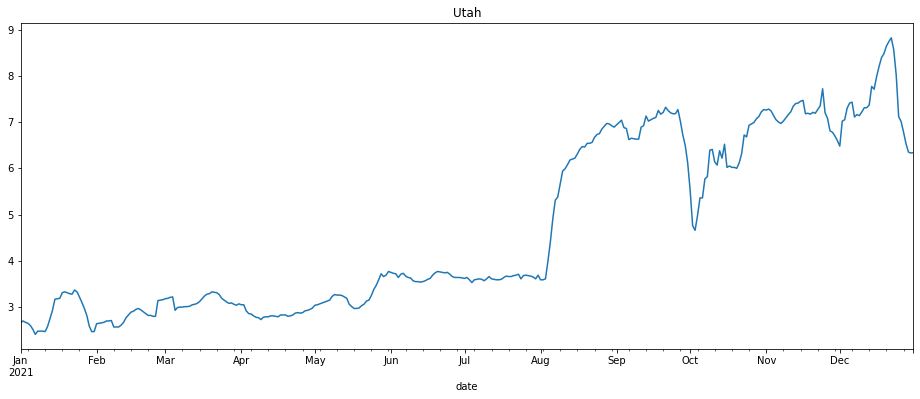

Utah 0.2348220353269988 5.775651072265637e-06
Utah 0.05366459058681078 0.30655339701591255
pearson from average Utah 0.4145231670238302 2.434926469609322e-16
spearman from average Utah 0.40576931506620045 1.1607193271593623e-15


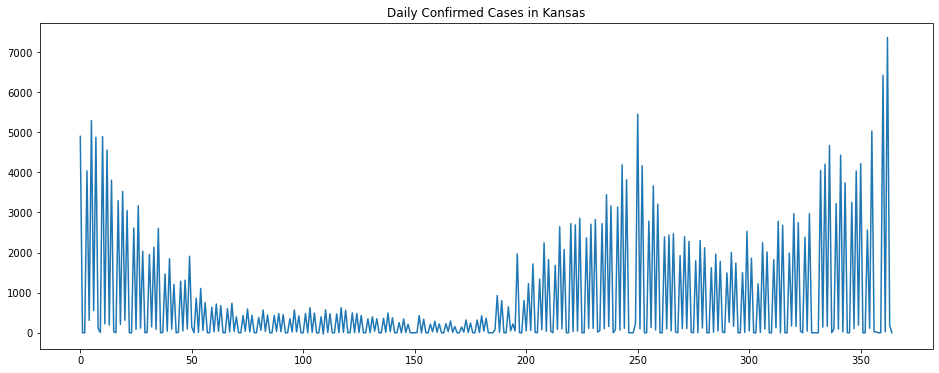

Kansas 0.19294258378405443 0.00020855428642459076
Kansas 0.05129059037894423 0.32847631990690485
pearson from average Kansas 0.48608672292645755 1.0926455111269327e-22
spearman from average Kansas 0.3554571798056482 3.9379866264223305e-12


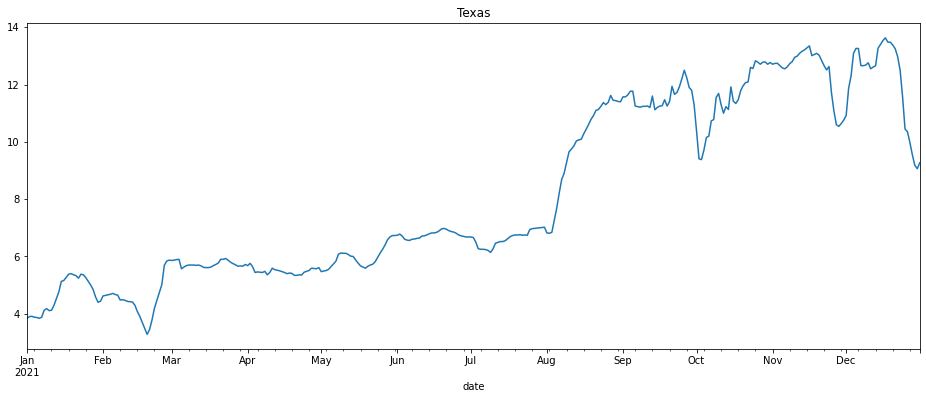

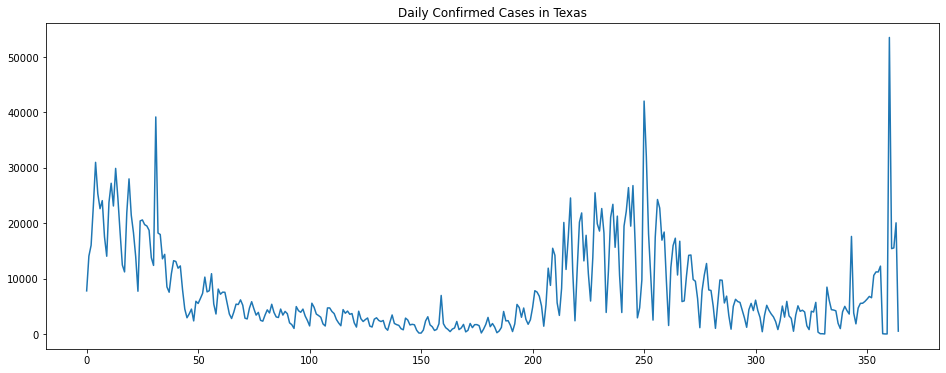

Texas 0.020903722846840677 0.6906016496544234
Texas -0.05427651711519013 0.3010627438160869
pearson from average Texas 0.038664010935419955 0.46520885118705896
spearman from average Texas -0.019241851844746083 0.7163485105069196


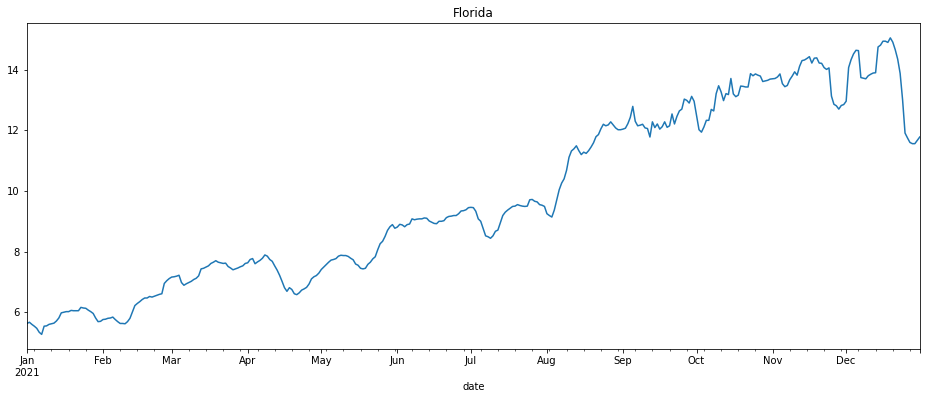

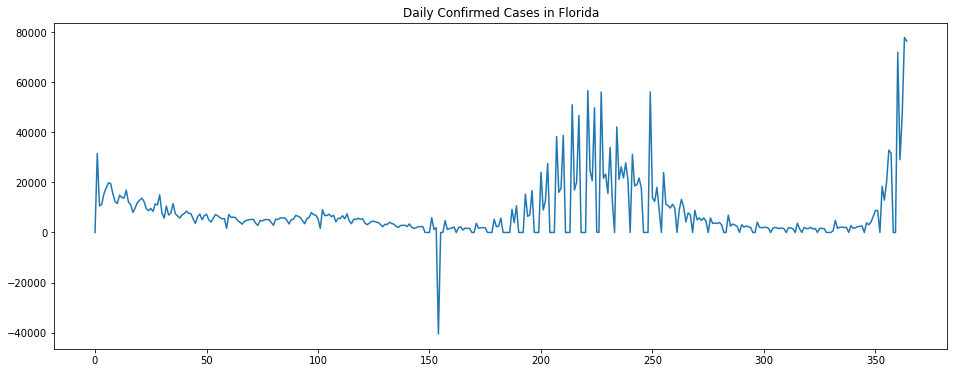

Florida 0.014550018027780106 0.7817502456271739
Florida -0.30535409310242123 2.574890855188543e-09
pearson from average Florida -0.00625551757499311 0.905978170777737
spearman from average Florida -0.2760705725459819 1.0594808824450598e-07


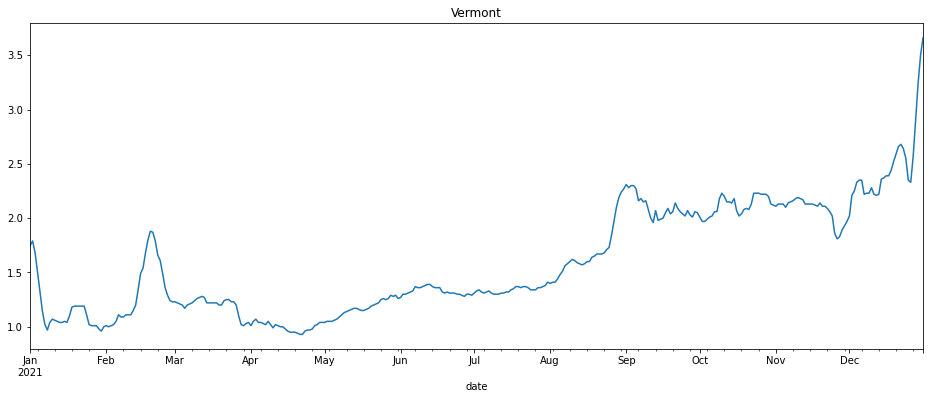

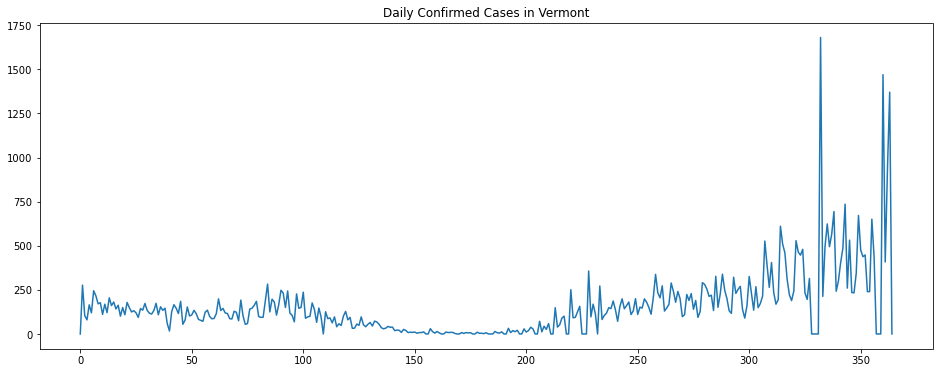

Vermont 0.5321724249902614 4.431867161841516e-28
Vermont 0.3884390166120808 1.3593836190983182e-14
pearson from average Vermont 0.7105118780386213 1.9348545919644748e-56
spearman from average Vermont 0.5395522359540014 1.6518549687945478e-28


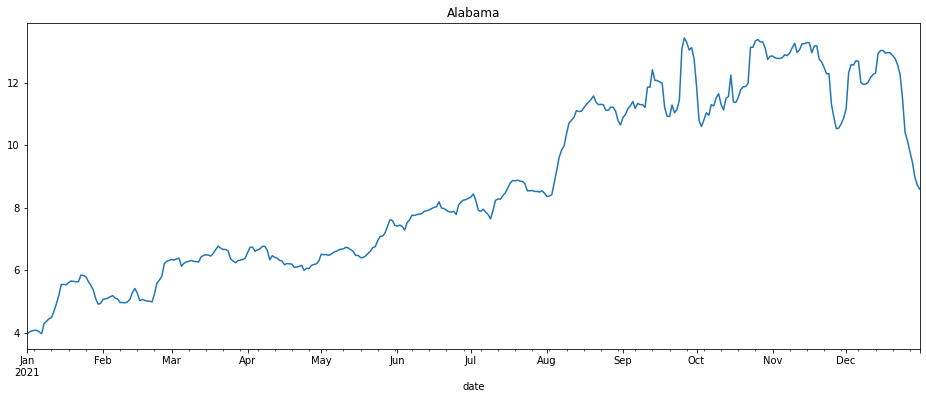

Alabama 0.07968775844914883 0.1286045112000527
Alabama 0.03875065364920842 0.46047308323031766
pearson from average Alabama 0.13361259600017508 0.011272349468441169
spearman from average Alabama 0.06406194024949184 0.22596767966513648


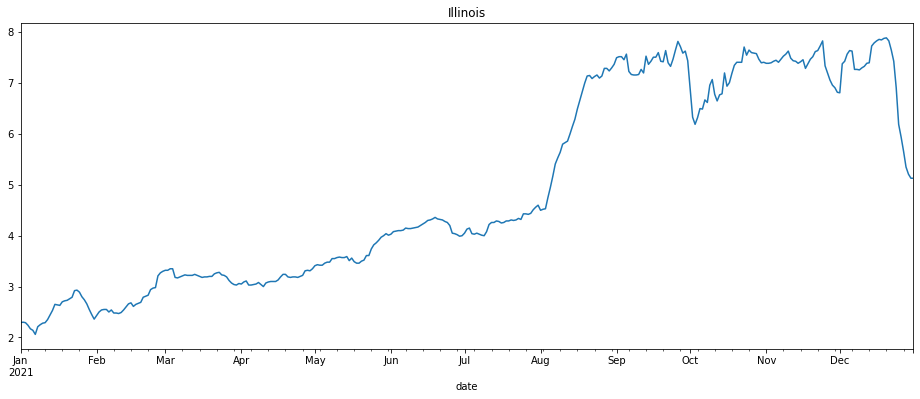

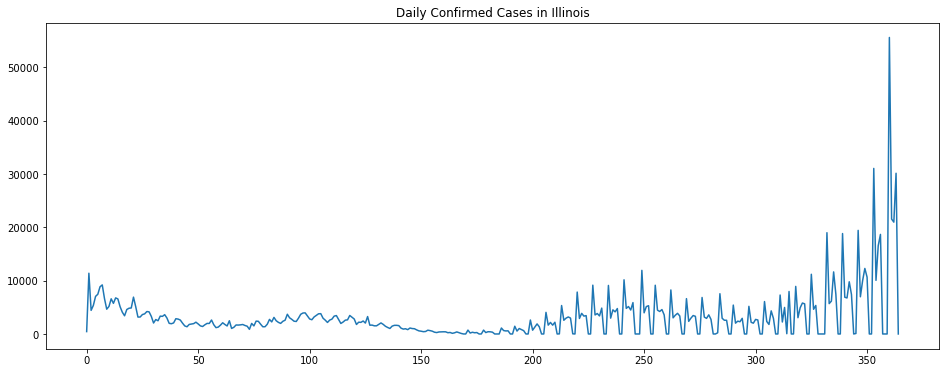

Illinois 0.1699955246781064 0.001112622336043641
Illinois -0.04016414821278024 0.4442645772161564
pearson from average Illinois 0.3221239813228695 4.119069661751993e-10
spearman from average Illinois 0.23007735110028185 1.0659009728477844e-05


Arkansas 0.03777127856027375 0.4718939959020812
Arkansas 0.1400913583984987 0.007351403323529156
pearson from average Arkansas 0.07646842780691597 0.1481954822464288
spearman from average Arkansas 0.18269682217428915 0.0005035470304059742


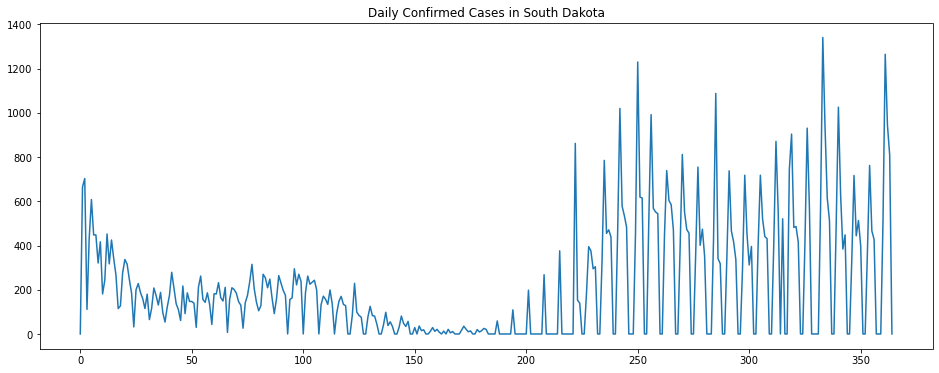

South Dakota 0.3723504457551541 1.9020052983587804e-13
South Dakota 0.10610699429010814 0.042770886493023026
pearson from average South Dakota 0.6629380800373341 8.411221820463057e-47
spearman from average South Dakota 0.4694910521317904 4.430422379737143e-21


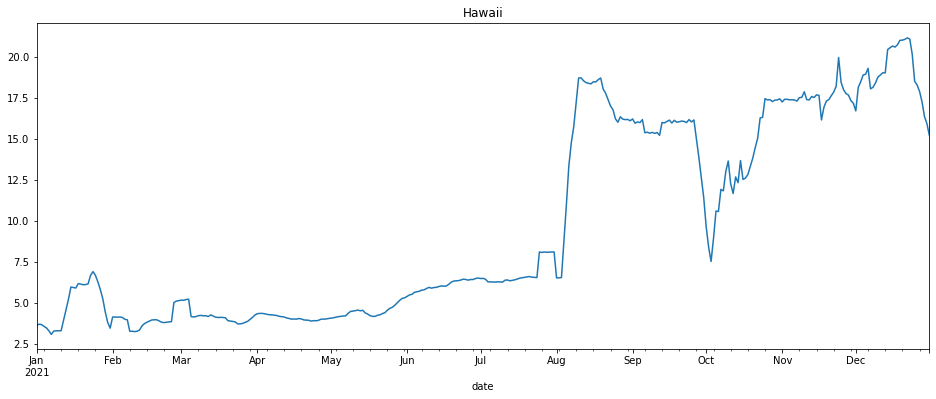

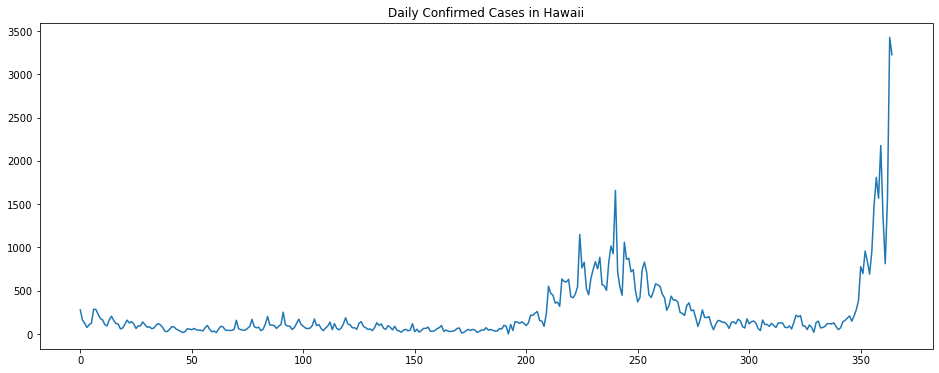

Hawaii 0.47735256170312235 3.5907123787308505e-22
Hawaii 0.5186719854407099 1.5936723156328917e-26
pearson from average Hawaii 0.5770171621678866 2.9794309236139474e-33
spearman from average Hawaii 0.5817173803980932 6.841082126976233e-34


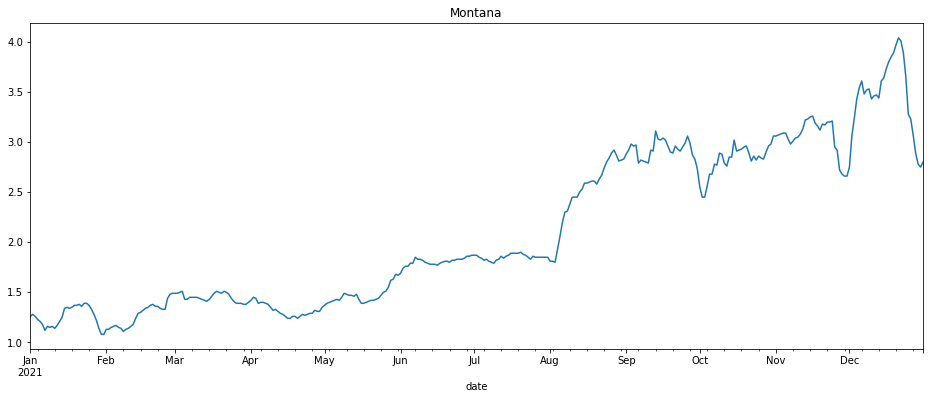

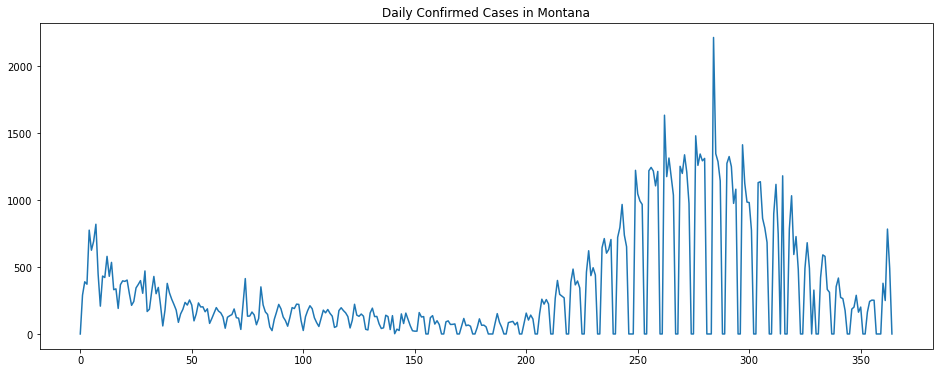

Montana 0.3608985902782891 1.1401970318435064e-12
Montana 0.06972842506730949 0.18377914797868405
pearson from average Montana 0.533391426814944 8.757701350939814e-28
spearman from average Montana 0.37140948980294947 3.47682758495801e-13


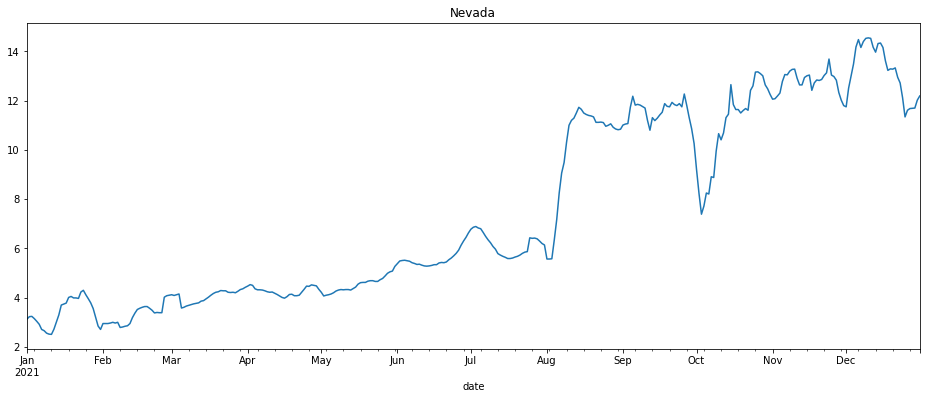

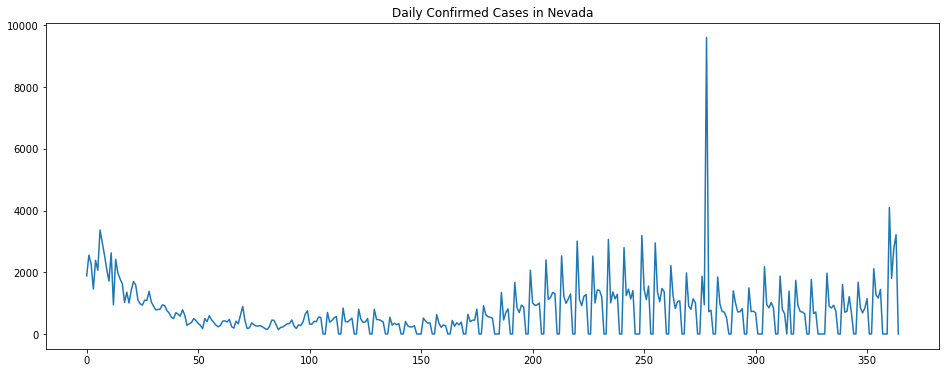

Nevada 0.09196727484369899 0.07930618865448436
Nevada 0.005499226848749129 0.9166114802622793
pearson from average Nevada 0.18945835943830872 0.00030625347566125066
spearman from average Nevada 0.2701119788846304 2.0257543056998504e-07


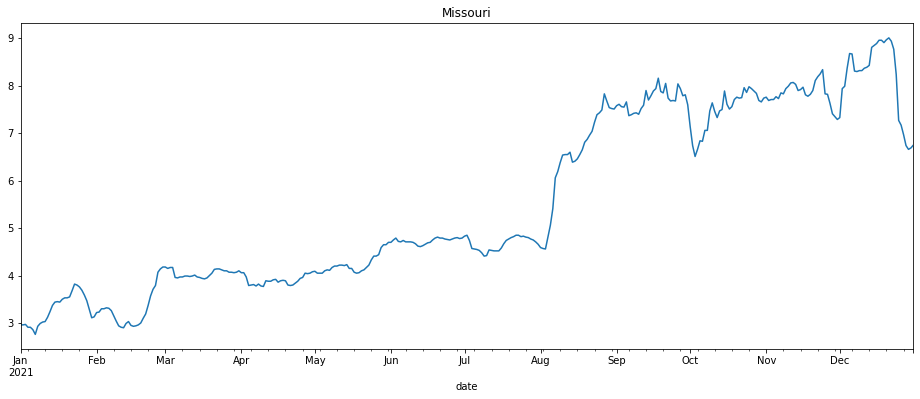

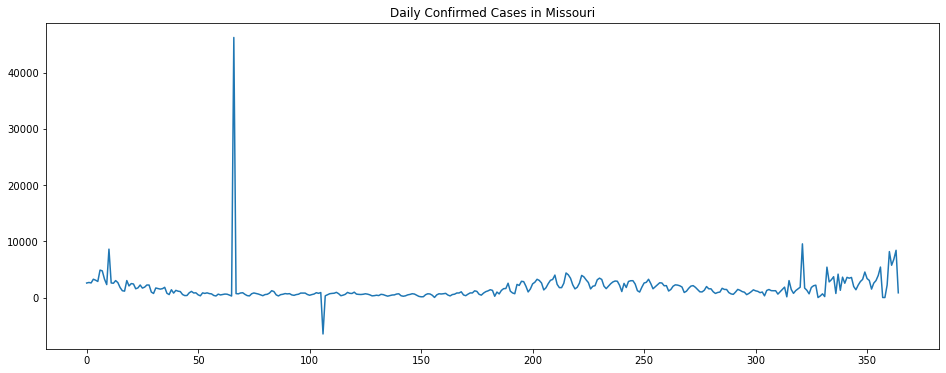

Missouri 0.11109170815854306 0.0338633167533529
Missouri 0.30711376049272454 2.0637135475659573e-09
pearson from average Missouri 0.24927426987711573 1.7329853776697299e-06
spearman from average Missouri 0.37890506895273585 1.0602691524021825e-13


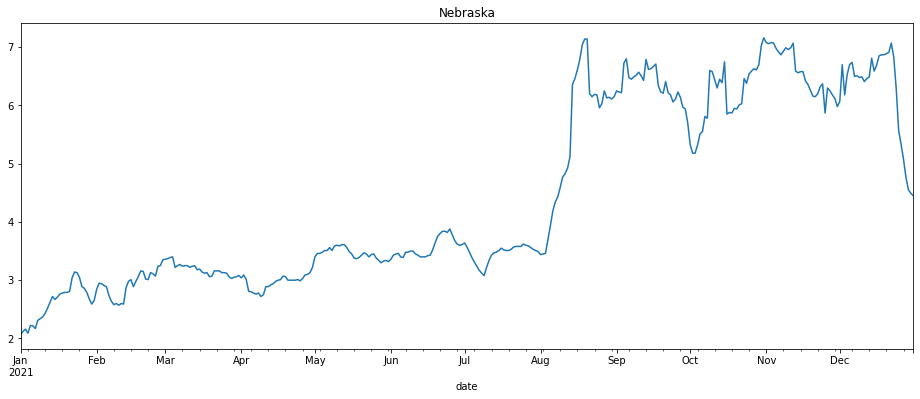

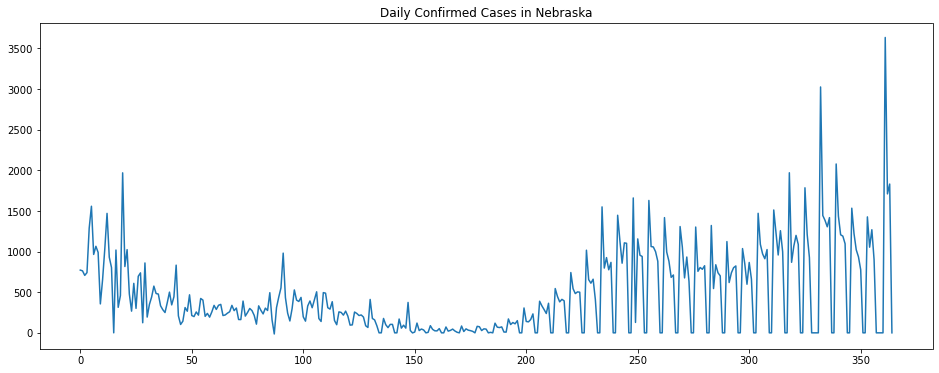

Nebraska 0.3544443438390625 3.0327350893078612e-12
Nebraska 0.09332107876412114 0.07496655344152532
pearson from average Nebraska 0.6336602356815413 1.0576348649780191e-41
spearman from average Nebraska 0.40292613962724916 1.908819079907612e-15


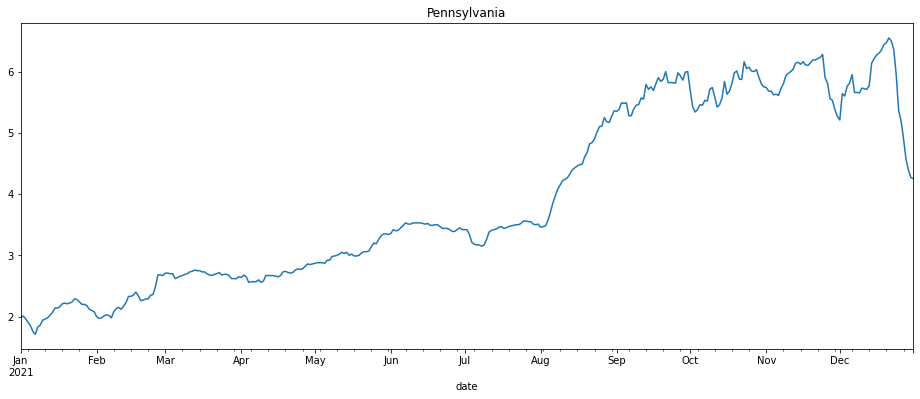

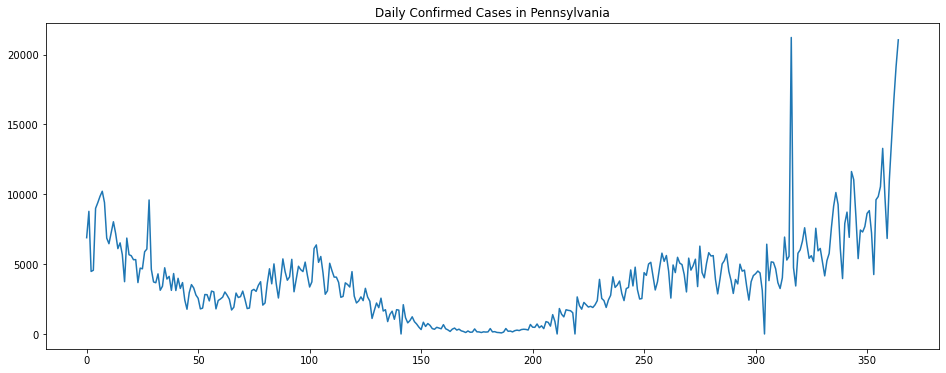

Pennsylvania 0.28985787942063757 1.697816944589865e-08
Pennsylvania 0.1782668313909499 0.0006226596319675395
pearson from average Pennsylvania 0.37007200242696403 4.2837304709637867e-13
spearman from average Pennsylvania 0.22255494431770725 2.0849056352367715e-05


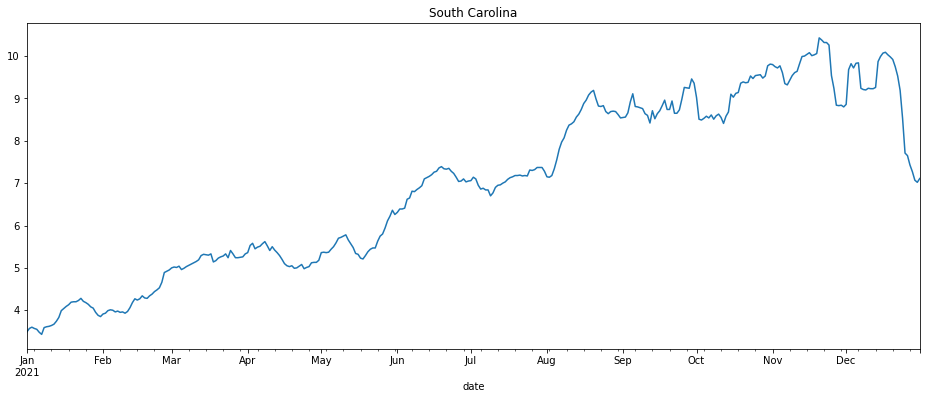

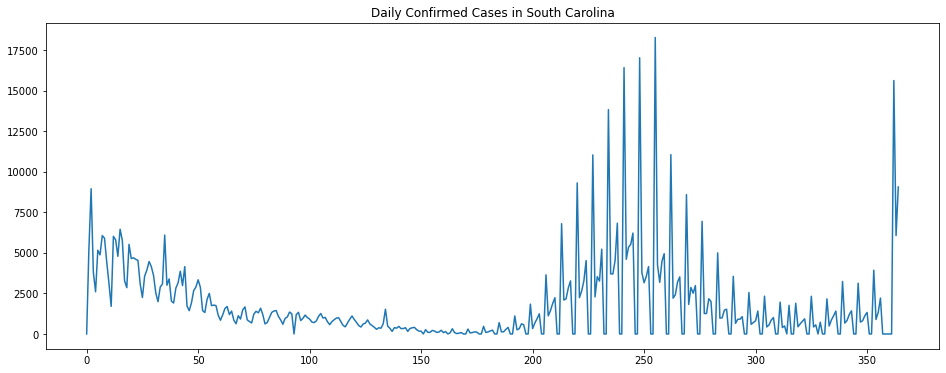

South Carolina -0.06825382591310646 0.19324736380411242
South Carolina -0.2650340977462811 2.772703593867262e-07
pearson from average South Carolina -0.09640737999123347 0.06807037088432552
spearman from average South Carolina -0.14009959725362828 0.007851870706406264


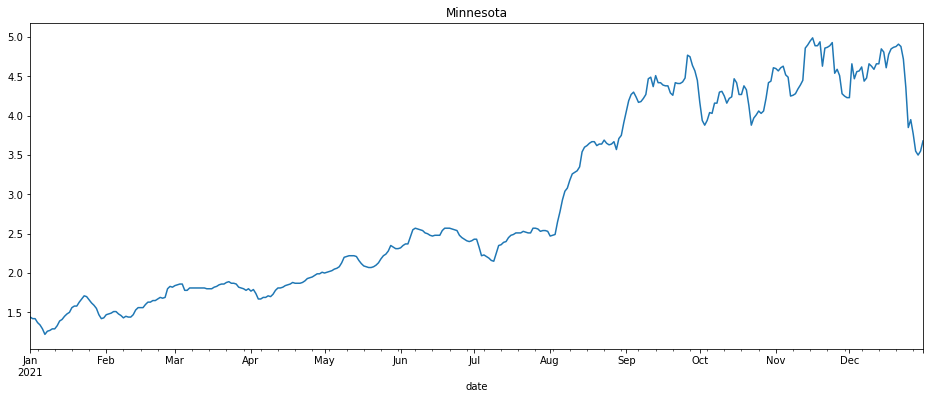

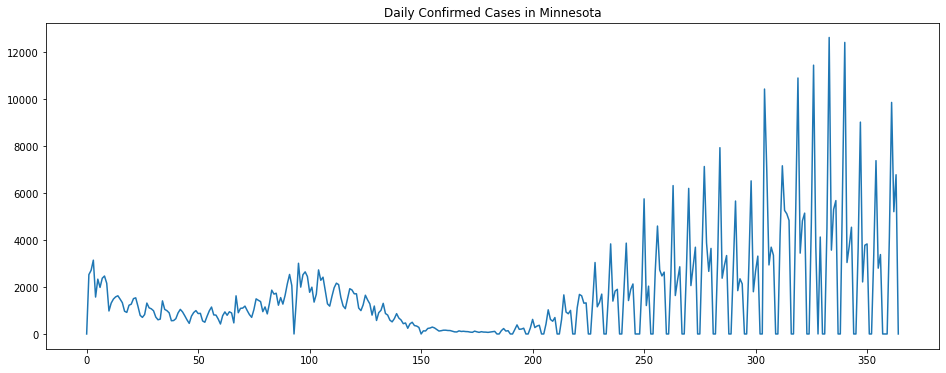

Minnesota 0.41257006483098924 1.9629652148414022e-16
Minnesota 0.12110662698930004 0.020649787566677843
pearson from average Minnesota 0.7085601746989867 5.250691213496932e-56
spearman from average Minnesota 0.5300229307959978 2.148974436053504e-27


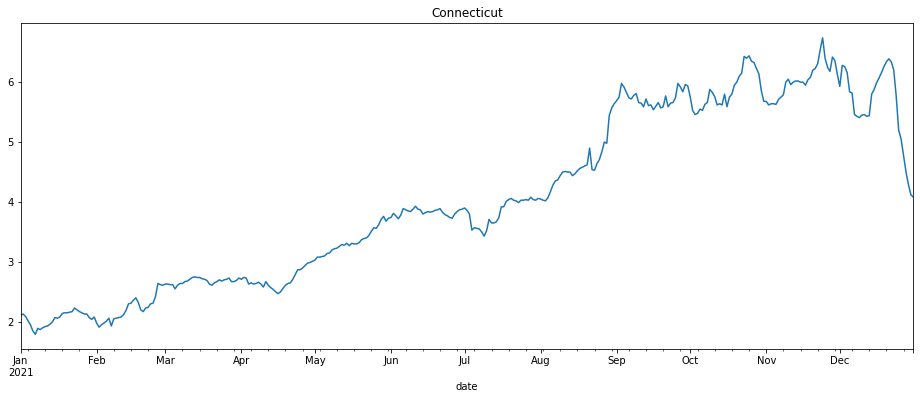

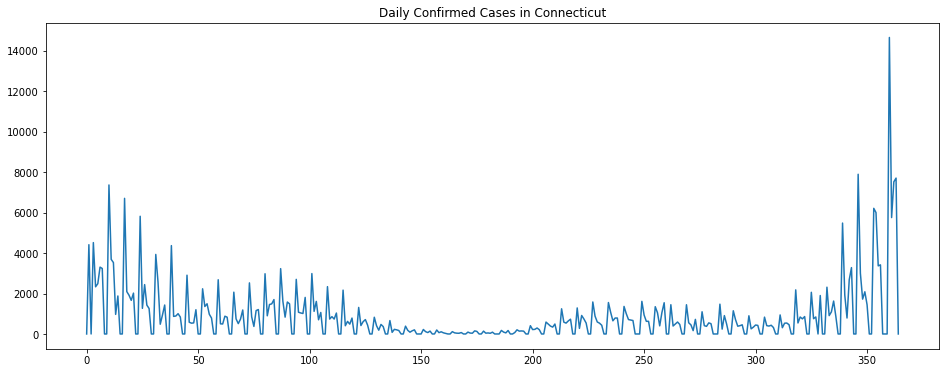

Connecticut -0.07549161821086886 0.15004489683711092
Connecticut -0.10950635438167781 0.03650720879784519
pearson from average Connecticut -0.12709492104535997 0.015975032125129296
spearman from average Connecticut -0.2897674501458745 2.250179130637506e-08


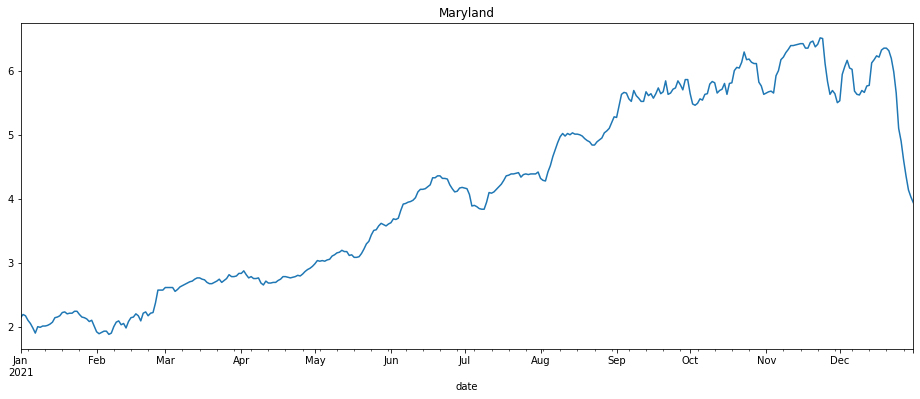

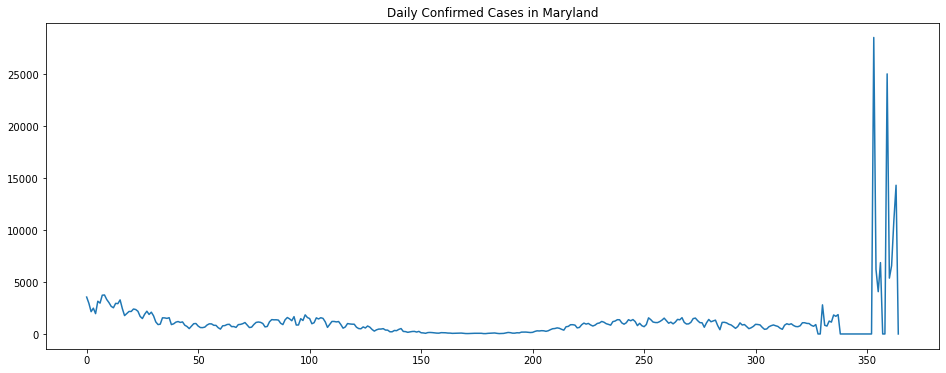

Maryland -0.005409408887655249 0.9179686223041145
Maryland -0.2326389385522347 7.086190433845618e-06
pearson from average Maryland 0.003310142293518792 0.9501649121713447
spearman from average Maryland -0.19101619370001396 0.00027243529384514983


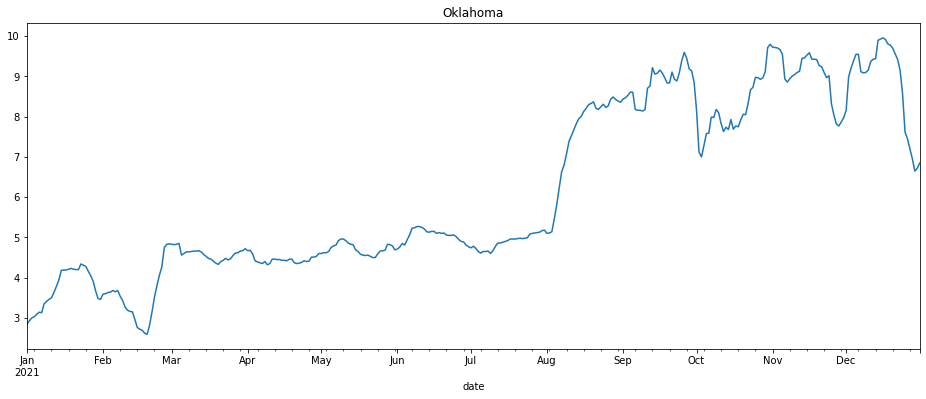

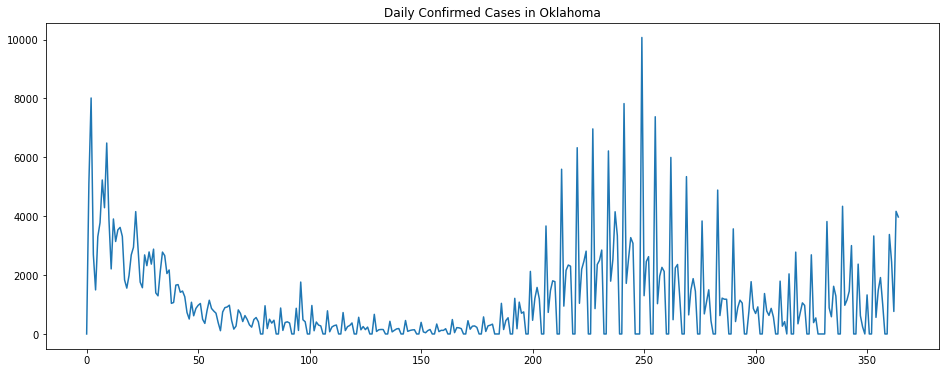

Oklahoma 0.06621156275903993 0.20694286755579253
Oklahoma -0.06740721783306694 0.19884205347892178
pearson from average Oklahoma 0.13684862137036657 0.009429053152096904
spearman from average Oklahoma 0.1530902776911627 0.0036410990400188607


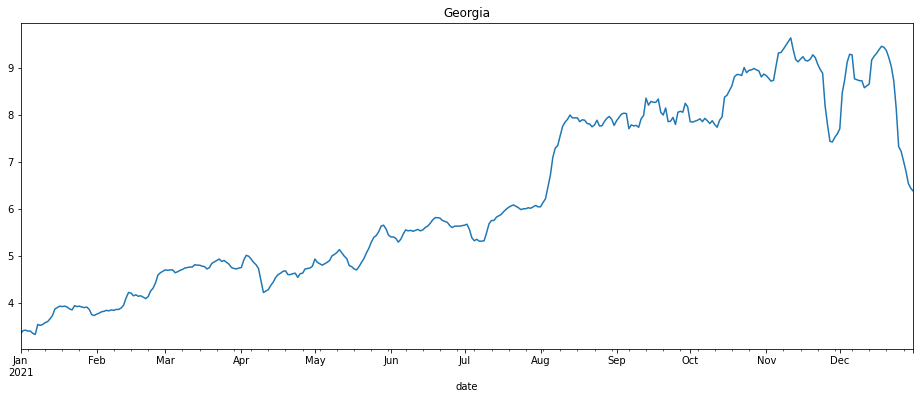

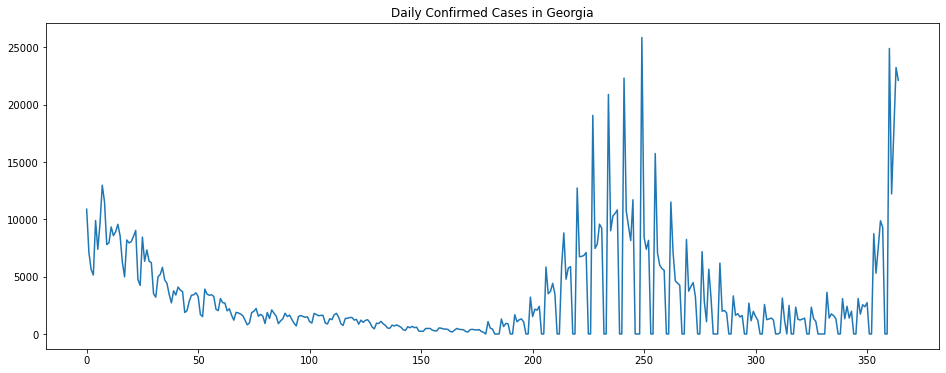

Georgia -0.005718338472123916 0.9133017446040682
Georgia -0.21574244624989233 3.229222466628164e-05
pearson from average Georgia 0.011168757026351749 0.8329759932228895
spearman from average Georgia -0.10318239944721812 0.05076913098388253


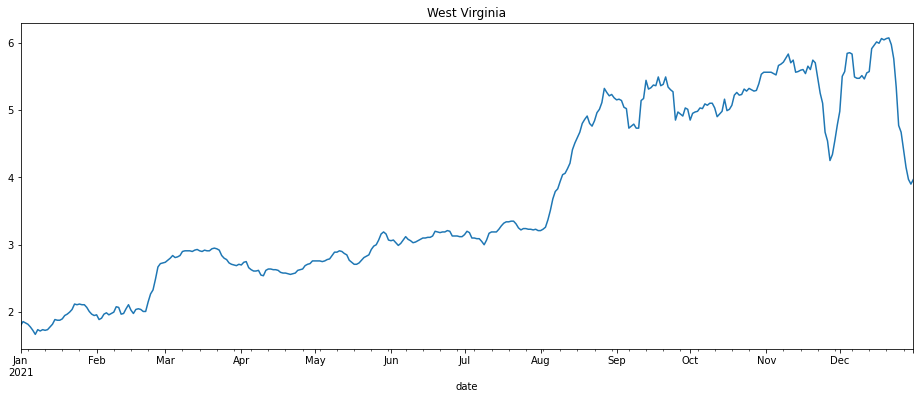

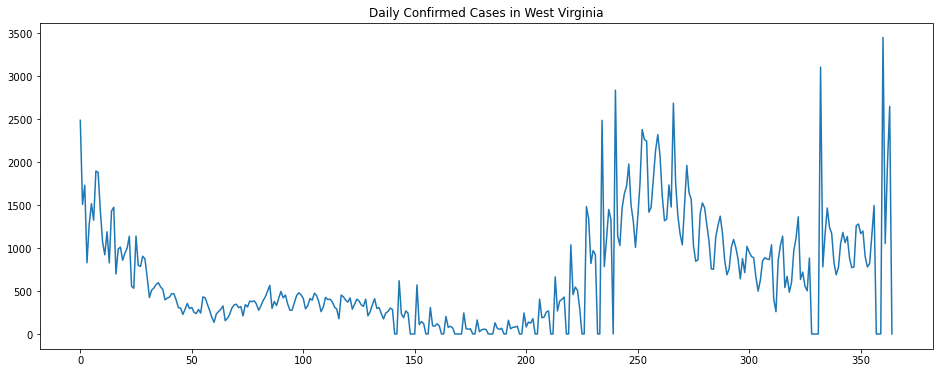

West Virginia 0.4225744451794977 3.0556932032776386e-17
West Virginia 0.2985094317032389 6.005730682908079e-09
pearson from average West Virginia 0.5559799080221599 1.6280167912464016e-30
spearman from average West Virginia 0.373407803452216 2.5408492302586837e-13


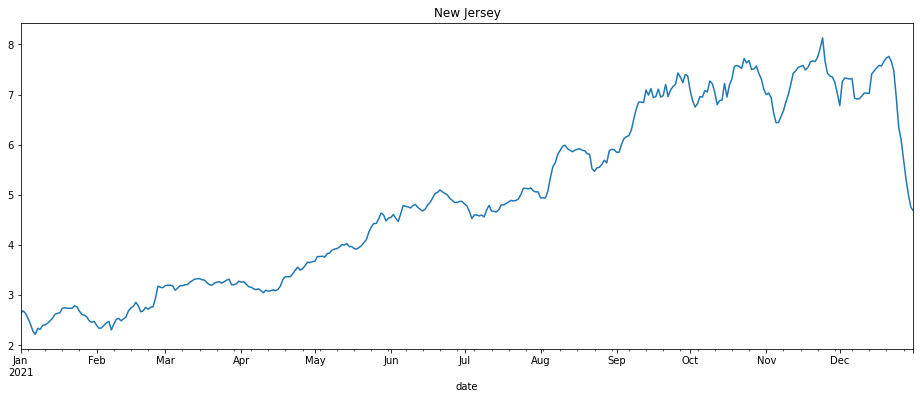

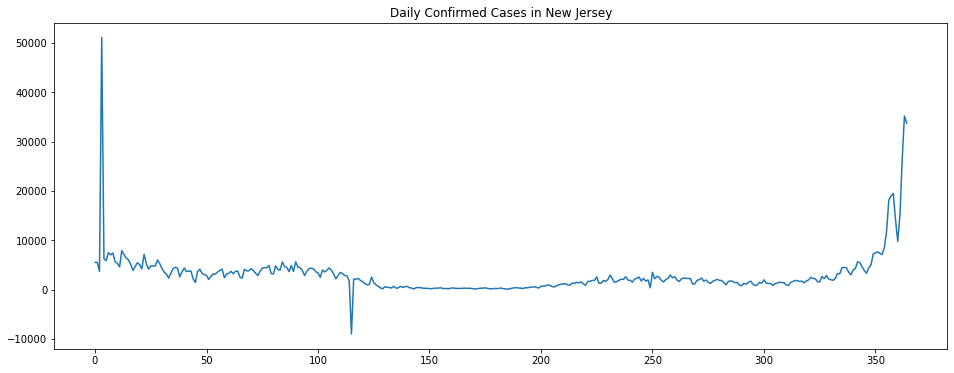

New Jersey -0.10899236046103591 0.037401152504165265
New Jersey -0.28056739357455457 4.988158932155335e-08
pearson from average New Jersey -0.1309647069836834 0.013010625915910436
spearman from average New Jersey -0.25484118551365065 9.944762129411725e-07


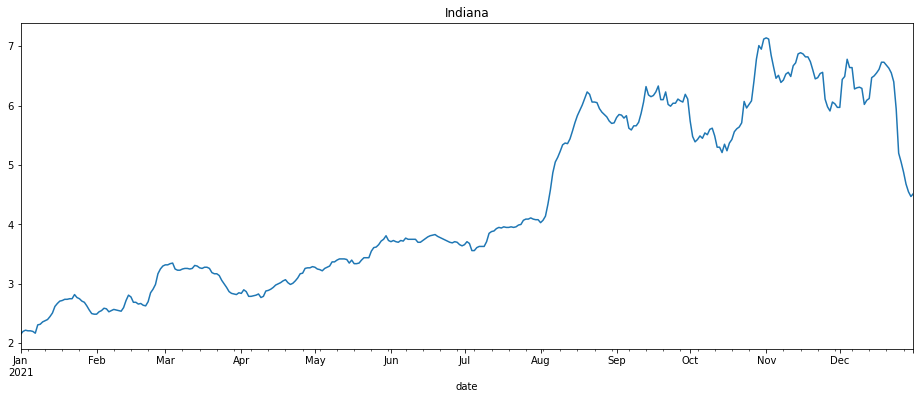

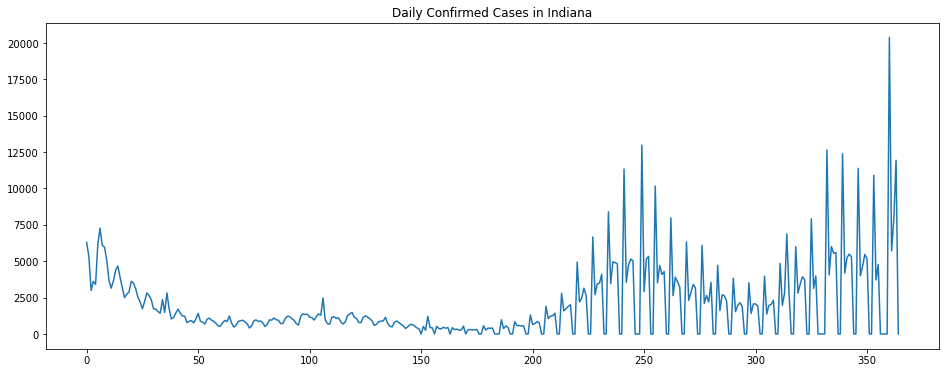

Indiana 0.26754800178103766 2.1158513850541121e-07
Indiana 0.03394175271158409 0.5180084876821942
pearson from average Indiana 0.508776378240513 4.934719554417602e-25
spearman from average Indiana 0.381802912529994 6.644025840023501e-14


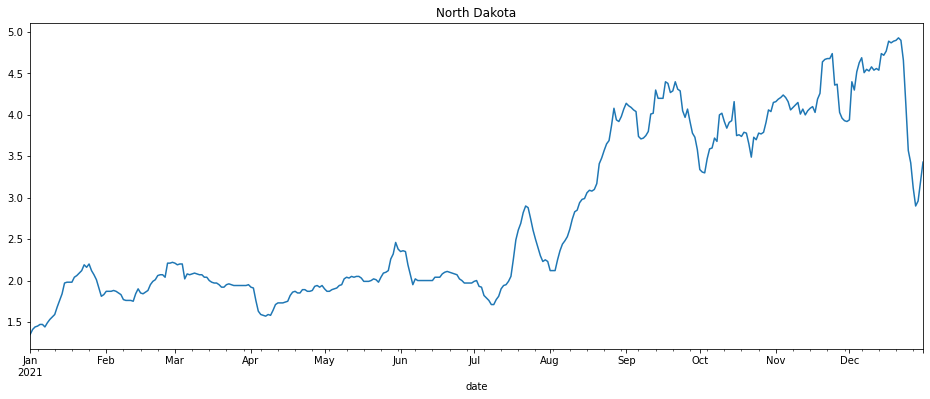

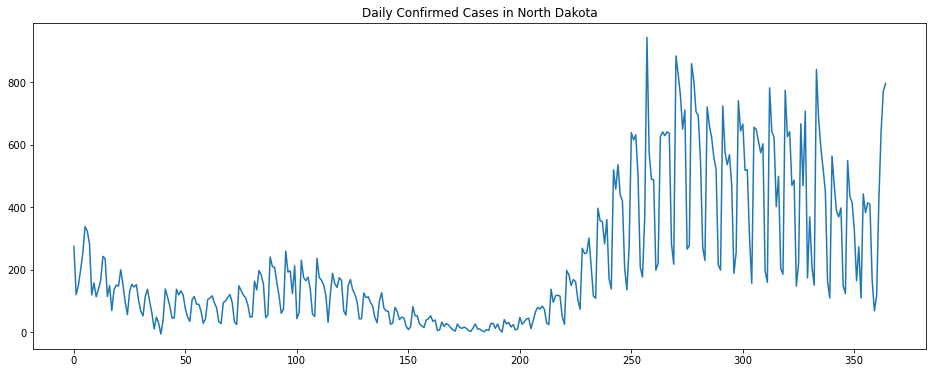

North Dakota 0.6877012176384896 2.0027389439418707e-52
North Dakota 0.5511107683319187 2.2013819016271418e-30
pearson from average North Dakota 0.8441247493563008 1.1290166503077525e-98
spearman from average North Dakota 0.5967089425564338 5.3222419686665795e-36


In [15]:
pearson_list = list()
spearman_list = list()

## Cuebiq Contact Index data
path="./2021data"
CCI_df=pd.read_csv(path+'/2021_state_cuebiq_CCI.txt',dtype=object,sep = ",")
states=list(CCI_df.columns)[1:]
# print(CCI_df.head())
# print(states)

# Hospitialization Data
path="./2021data"
hospitial_data = pd.read_csv(path+'/nyt-us-states.csv')
#print(hospitial_data.head())


for state in states:
    df = CCI_df[["date",state]]
    df.set_index("date",inplace = True)
    distance_df = df.copy()
    distance_df.index = pd.to_datetime(distance_df.index) # convert to datetime
    distance_df.columns=['Distance']
    distance_df['Distance'] = pd.to_numeric(distance_df['Distance'])
    distance_df.sort_index(ascending=True) # select ranges of dates, sort the rows by date first
    #     start = distance_df.index.searchsorted(dt.datetime(2020, 5, 12))
    #     end = distance_df.index.searchsorted(dt.datetime(2020, 8, 15))
    #     distance_df = distance_df.iloc[start:end]
    distance_df['Distance'].plot(figsize = (16,6))
    plt.title(state)
    plt.show()

    df = hospitial_data[hospitial_data['state'] == state]
    #df['date'] = pd.to_datetime(df['date'])
    start_date = '2021-01-01'
    end_date = '2021-12-31'
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    state_hospitial_data = df.set_index('date')
    state_hospitial_data.sort_index(ascending=True,inplace = True)    
    #     start = df.index.searchsorted(start_date)
    #     end = df.index.searchsorted(end_date)
    #     state_hospitial_data = df.iloc[start:end]
    # state_hospitial_data['cases'].plot(figsize = (16,6))
    # plt.show()
    y=state_hospitial_data['cases']
    prev = hospitial_data[(hospitial_data['state'] == state)&(hospitial_data['date'] == '2020-12-31')]["cases"].iloc[0]
    daily_hospitial_data = [None] * len(y)
    for i in range(1,len(y)):
        daily_hospitial_data[i] = y[i] - y[i-1]
    daily_hospitial_data[0] = y[0]-prev
    #print(daily_hospitial_data)
    pd.Series(daily_hospitial_data).plot(figsize = (16,6))
    plt.title("Daily Confirmed Cases in "+state)
    plt.show()
    ## Correlation
    x = np.array(distance_df['Distance'])
    x = x.astype(float)
    y = np.array(state_hospitial_data['cases'])
    r, p = scipy.stats.pearsonr(x, daily_hospitial_data)
    print(state,r,p)
    r, p = scipy.stats.spearmanr(x, daily_hospitial_data)
    print(state,r,p)
    daily_cases_moving_average = moving_average(daily_hospitial_data,7)
    x_moving_average = moving_average(x,7)
    r, p = scipy.stats.pearsonr(x_moving_average, daily_cases_moving_average)
    print("pearson from average",state,r,p)
    pearson_list.append(r)
    r, p = scipy.stats.spearmanr(x_moving_average, daily_cases_moving_average)
    print("spearman from average",state,r,p)
    spearman_list.append(r)

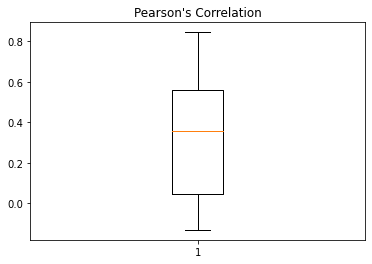

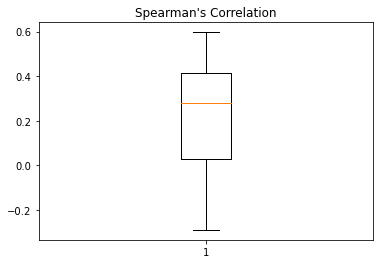

In [16]:
plt.boxplot(pearson_list)
plt.title("Pearson's Correlation")
plt.show()

plt.boxplot(spearman_list)
plt.title("Spearman's Correlation")
plt.show()

In [17]:
pearson_list

[0.06967126493767728,
 0.5521037382748457,
 0.15015638657320518,
 0.5585747417782356,
 -0.01438950261190371,
 0.5656272504083263,
 0.021217985092908377,
 0.3586806466015092,
 0.5727321646995633,
 0.17370496854210038,
 0.19364880623075148,
 -0.03996607813130012,
 0.559544258383571,
 0.5448898324405722,
 0.021754747505988555,
 0.6304069616014087,
 0.03724160306081479,
 0.7090338689809679,
 0.6877626717591643,
 0.053347597608010555,
 0.5280660332293712,
 0.4001061764171815,
 0.25943756286068215,
 0.3952885259979211,
 0.42096077158400136,
 -0.09097752849889382,
 0.4145231670238302,
 0.48608672292645755,
 0.038664010935419955,
 -0.00625551757499311,
 0.7105118780386213,
 0.13361259600017508,
 0.3221239813228695,
 0.07646842780691597,
 0.6629380800373341,
 0.5770171621678866,
 0.533391426814944,
 0.18945835943830872,
 0.24927426987711573,
 0.6336602356815413,
 0.37007200242696403,
 -0.09640737999123347,
 0.7085601746989867,
 -0.12709492104535997,
 0.003310142293518792,
 0.13684862137036657,


In [18]:
spearman_list

[0.02810051740439282,
 0.42655904889800045,
 0.04948426696402557,
 0.47371322152394735,
 -0.05670535920730635,
 0.5692699851614392,
 0.0273880049939729,
 0.2801026339370046,
 0.5254911110472229,
 0.15146509272553635,
 0.13528183158532942,
 0.14461912796802534,
 0.4461695314891046,
 0.4025911636111696,
 -0.20658897867829487,
 0.4536854745231329,
 -0.08362390439412785,
 0.5014672104343411,
 0.47010191136839674,
 -0.13690454423488466,
 0.3628743422731166,
 0.36410130952786346,
 0.3931752192560838,
 0.26312144764224665,
 0.28720515404810326,
 -0.04621754094935869,
 0.40576931506620045,
 0.3554571798056482,
 -0.019241851844746083,
 -0.2760705725459819,
 0.5395522359540014,
 0.06406194024949184,
 0.23007735110028185,
 0.18269682217428915,
 0.4694910521317904,
 0.5817173803980932,
 0.37140948980294947,
 0.2701119788846304,
 0.37890506895273585,
 0.40292613962724916,
 0.22255494431770725,
 -0.14009959725362828,
 0.5300229307959978,
 -0.2897674501458745,
 -0.19101619370001396,
 0.15309027769116

## Changepoint Detection For Wisconsin

In [19]:
def changepoint_ind(data,plot = False):
    data = np.array(data).reshape(len(data),1)
    prior_function = partial(const_prior, p=1/(len(data) + 1))
    Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)
    psum = np.exp(Pcp).sum(0)
    if plot:
        fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
        ax[0].plot(data[:])
        ax[1].plot(np.exp(Pcp).sum(0))
    changepoints = []
    candidate_ind = argrelextrema(psum, np.greater)
    for ind in candidate_ind[0]:
        if psum[ind]>0.1:
            changepoints.append(ind)
    return changepoints

## Find good changepoints for all states

In [23]:
path="./2021data/"
df=pd.read_csv(path+'2021_state_cuebiq_CCI.txt',dtype=object,sep = ",")
df.set_index("date",inplace = True)

In [24]:
df

North Carolina Colorado District of Columbia Oregon Louisiana  \
date                                                                       
2021-01-01           2.98     2.44                  1.6   1.45      3.36   
2021-01-02           3.01     2.46                 1.74   1.46       3.4   
2021-01-03            3.0     2.44                 1.68   1.46      3.39   
2021-01-04           2.96     2.38                 1.62   1.41      3.44   
2021-01-05           2.89     2.31                 1.71   1.36      3.52   
...                   ...      ...                  ...    ...       ...   
2021-12-27           6.26     5.57                 4.25    4.3       8.7   
2021-12-28           6.06     5.45                 4.36   3.98      8.23   
2021-12-29           5.87     5.42                  5.0   3.72      7.79   
2021-12-30           5.86      5.5                 5.11   3.55      7.62   
2021-12-31            5.9     5.56                  5.2   3.57       7.7   

           Wyoming Virginia Kentucky Alaska Mississippi  ... South Carolina  \
date                                                     ...                  
2021-01-01    1.21     1.74     2.14   0.67        2.58  ...           3.49   
2021-01-02    1.21     1.77     2.21   0.66         2.6  ...           3.57   
2021-01-03    1.19     1.75     2.23   0.65        2.64  ...            3.6   
2021-01-04    1.19     1.72     2.22   0.64        2.68  ...           3.57   
2021-01-05     1.2     1.69      2.2   0.65        2.76  ...           3.55   
...            ...      ...      ...    ...         ...  ...            ...   
2021-12-27    2.91     3.64     5.01   3.25         6.5  ...           7.43   
2021-12-28    2.84     3.53     4.81   3.11        6.16  ...           7.27   
2021-12-29    2.77     3.43     4.69   2.89         5.8  ...           7.07   
2021-12-30    2.76     3.37     4.64   2.78        5.69  ...           7.02   
2021-12-31    2.83     3.36     4.73   2.85        5.69  ...           7.11   

           Minnesota Connecticut Maryland Oklahoma Georgia West Virginia  \
date                                                                       
2021-01-01      1.44        2.11     2.15     2.85    3.36           1.8   
2021-01-02      1.42        2.13      2.2     2.93    3.42          1.86   
2021-01-03      1.42        2.09     2.18      3.0    3.43          1.84   
2021-01-04      1.37        2.02     2.11     3.03    3.41          1.82   
2021-01-05      1.34        1.95     2.06     3.09    3.41          1.78   
...              ...         ...      ...      ...     ...           ...   
2021-12-27      3.77        4.78     4.61      7.2    7.02          4.41   
2021-12-28      3.55         4.5     4.36     6.95     6.8          4.15   
2021-12-29       3.5        4.29     4.14     6.65    6.54          3.97   
2021-12-30      3.55        4.12     4.03     6.72    6.44           3.9   
2021-12-31      3.68        4.08     3.94     6.85    6.38          3.97   

           New Jersey Indiana North Dakota  
date                                        
2021-01-01       2.64    2.15         1.35  
2021-01-02       2.69     2.2         1.41  
2021-01-03       2.64    2.22         1.44  
2021-01-04       2.54    2.21         1.45  
2021-01-05       2.43    2.21         1.47  
...               ...     ...          ...  
2021-12-27        5.7    4.88         3.12  
2021-12-28       5.31    4.68          2.9  
2021-12-29        5.0    4.55         2.96  
2021-12-30       4.75    4.47          3.2  
2021-12-31       4.68    4.52         3.43  

[365 rows x 51 columns]

In [25]:
df = df.T.astype(float)

In [26]:
avg_CCI = df.mean(axis = 0)

[54, 142, 216]

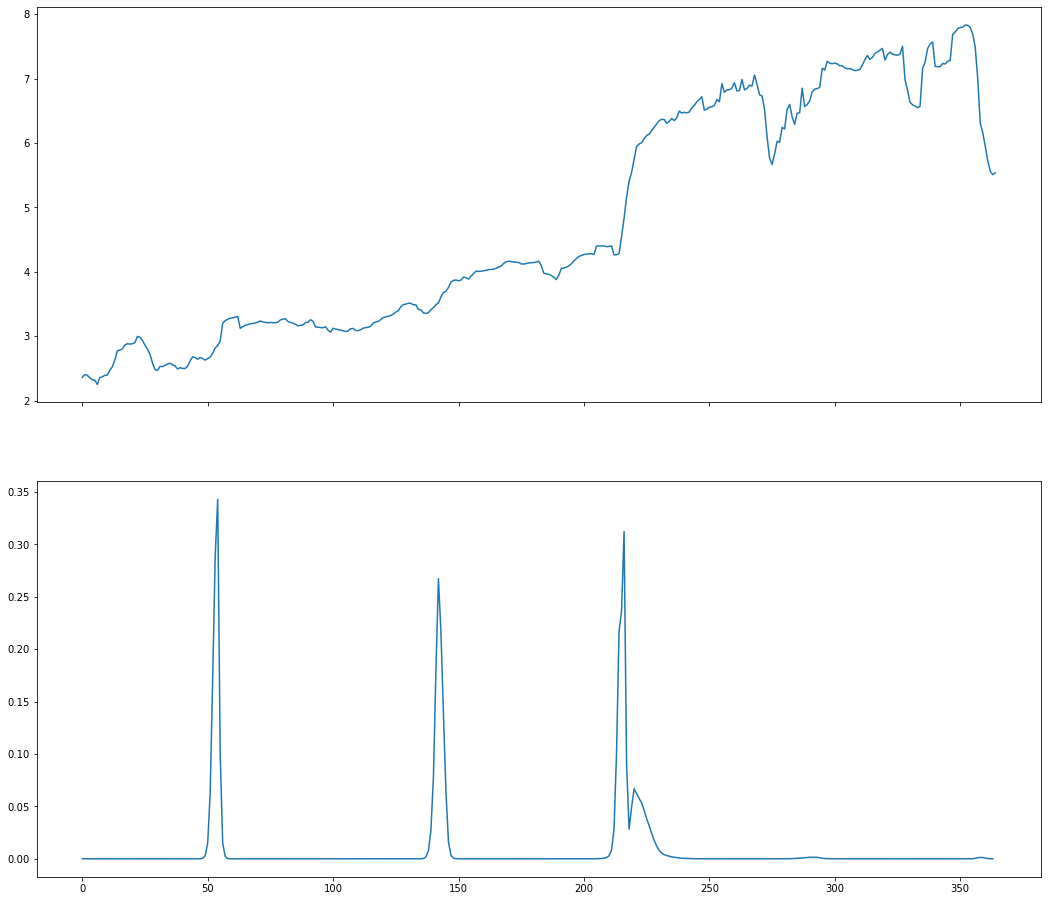

In [27]:
changepoint_ind(avg_CCI,True)

In [32]:
avg_CCI.index[142]

'2021-05-23'

In [33]:
avg_CCI.index[216]

'2021-08-05'